In [258]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import powerlaw
from scipy.stats import combine_pvalues, norm
import statsmodels.api as sm
from statsmodels.formula.api import ols
import glob
import ast
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.stattools import adfuller


# Plots and testing for Hypothesis 1

In [259]:
def analyze_time_series(ts1, ts2):
    correlation = np.corrcoef(ts1, ts2)[0, 1]
    adf_ts1 = adfuller(ts1)
    adf_ts2 = adfuller(ts2)
    combined_ts = np.column_stack((ts1, ts2))
    
    # VAR Model fitting based on BIC
    var_model = VAR(combined_ts)
    var_model_fitted = var_model.fit(ic='bic')
    var_bic = var_model_fitted.bic
    var_lag_order = var_model_fitted.k_ar
    var_model_fitted.summary()
    
    # Johansen's Cointegration Test
    johansen_test = coint_johansen(combined_ts, det_order=-1, k_ar_diff=var_lag_order-1)
    coint_rank = np.sum(johansen_test.lr1 > johansen_test.cvt[:, 1])
    
    vecm_results = {}
    if coint_rank > 0:
        vecm_model = VECM(combined_ts, k_ar_diff=var_lag_order-1, coint_rank=coint_rank, deterministic='ci')
        vecm_model_fitted = vecm_model.fit()
        vecm_model_fitted.summary()

        
        # Extracting more detailed parameters from VECMResults
        vecm_results = {
            'cointegrating_eq_coefficients': vecm_model_fitted.beta,
            'adjustment_coefficients': vecm_model_fitted.alpha,
        }
    
    # VAR and VECM model diagnostics
    var_results = {
        'var_residuals_test': var_model_fitted.test_whiteness().summary().data[1][2],  # Test for autocorrelation in VAR residuals
        # Additional diagnostics can be included as needed
    }
    
    # Combining results
    results = {
        'correlation': correlation,
        'adf_statistic_ts1': adf_ts1[0], 'adf_pvalue_ts1': adf_ts1[1],
        'adf_statistic_ts2': adf_ts2[0], 'adf_pvalue_ts2': adf_ts2[1],
        'var_bic': var_bic, 'var_lag_order': var_lag_order, 'coint_rank': coint_rank,
        **vecm_results,  # Unpacking VECM results if available
        **var_results  # Including model diagnostics
    }
    

    print(results)
    # Convert results to a structured output
    results_df = pd.DataFrame([results])
    
    
    if coint_rank > 0:
        print("\nVECM Model Summary:")
        print(vecm_model_fitted.summary())

    if coint_rank == 0:
        print("\nVAR Model Summary:")
        print(var_model_fitted.summary())
    
    return results_df

### Our model

In [260]:
path = R'C:\Users\nitai\OneDrive\MScCLS\Complex system simulation\FinancialNetwork\Data our model'


In [261]:
def get_files_with_parameters(directory_path, input_parameters):
    # Read all files in the directory
    
    all_files = os.listdir(directory_path)
    print('all files in directory: ', all_files)

    # List to hold DataFrames of files that match the input parameters
    matching_files_data = []

    for filename in all_files:
        # Split the filename on the first underscore to drop the initial number sequence
        parts = filename.split('_', 1)
        if len(parts) == 2:
            # Split the parameters part on the last underscore to drop the timestamp
            prefix, parameters_with_timestamp = parts
            parameters = '_'.join(parameters_with_timestamp.split('_')[:-1])
            
            # Check if the file parameters match the input parameters
            if input_parameters in parameters:
                # Construct the full path to the file
                file_path = os.path.join(directory_path, filename)
                # Read the CSV file into a DataFrame
                df = pd.read_csv(file_path)
                # Add the DataFrame to the list
                matching_files_data.append(df)

    return matching_files_data

In [262]:
input_parameters = '2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate'

# Get the matching files
selected_files = get_files_with_parameters(path, input_parameters)

all files in directory:  ['100_2000_1_1_1_5_1_3_200_hard cutoff_divide exposure singly_intrest_rate_20240131000358.csv', '100_2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240131000537.csv', '100_2000_1_1_1_5_1_3_600_hard cutoff_divide exposure singly_intrest_rate_20240131000716.csv', '100_2000_1_2_1_5_1_3_200_hard cutoff_divide exposure singly_intrest_rate_20240131000851.csv', '100_2000_1_2_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240131001028.csv', '100_2000_1_2_1_5_1_3_600_hard cutoff_divide exposure singly_intrest_rate_20240131001205.csv', '100_2000_1_4_1_5_1_3_200_hard cutoff_divide exposure singly_intrest_rate_20240131001336.csv', '100_2000_1_4_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240131001508.csv', '100_2000_1_4_1_5_1_3_600_hard cutoff_divide exposure singly_intrest_rate_20240131001640.csv', '100_200_1_1_1_2_2_2_1_hard cutoff_divide exposure singly_exposure_20240130232202.csv', '100_200_1_1_1_2_2_2_1_hard cut

In [263]:
def select_variable_given_list_of_dfs(selected_dfs: list, variable_name: str):
    # List to hold Series or lists of the selected variable from each DataFrame
    list_of_series_or_lists = []

    for df in selected_dfs:
        # Check if the variable_name column exists to avoid KeyError
        if variable_name in df.columns:

            # Drop first row from the DataFrame
            df = df.drop(df.index[0])

            # Extract the variable column as it contains NANs
            variable_series = df[variable_name]
            
            # Since the column is an object type (possibly containing lists or arrays), 
            # no conversion to numeric is done here. Instead, we directly append the column.
            list_of_series_or_lists.append(variable_series)
        else:
            print(f"The variable '{variable_name}' is not in the DataFrame.")
    return list_of_series_or_lists

In [264]:
data_our_model_bankruptcy = select_variable_given_list_of_dfs(selected_files, 'Abs Difference of Bankrupt Agents Over Time')

In [265]:
def convert_string_to_list(string):
    # Remove the square brackets
    string = string.strip('[]')
    # Split the string on commas
    string = string.split(',')
    # Convert each string in the list to a float
    string = [float(s) for s in string]
    return string

In [266]:
titles = ['100 Agents', '200 Agents', '300 Agents']

In [267]:
def plot_bankruptcy_analysis_multiple_arrays(selected_files, titles, param_caption):
    """
    Plots the bankruptcy analysis with three subplots for each file in data_array.
    :param data_array: List of pandas DataFrames with bankruptcy data.
    """
    bankrupty_df = select_variable_given_list_of_dfs(selected_files, 'Abs Difference of Bankrupt Agents Over Time')
    energy_in_link_df = select_variable_given_list_of_dfs(selected_files, 'Absolute Exposure in Edge Weights')
    for file_index, file in enumerate(selected_dfs):
        plt.figure(figsize=(10, 12))
        for run in range(file.shape[0]):
            print(file.columns)
            diff_bankrupt_agents = file.iloc[run]
            diff_bankrupt_agents = convert_string_to_list(diff_bankrupt_agents)
            time_steps = np.arange(len(diff_bankrupt_agents))

            # Subplot 1: Difference in Number of Bankrupt Agents
            plt.subplot(4, 1, 1)
            plt.plot(time_steps, diff_bankrupt_agents, label=f'Run {run+1}', color='orange')
            plt.xlabel('Time Step')
            plt.ylabel('Difference in Number of Bankrupt Agents')
            plt.title(f'N = {titles[file_index]} - Difference in Number of Bankrupt Agents Over Time')
            plt.legend()

            # Subplot 2: Cumulative Histogram of Absolute Difference in Bankrupt Agents
            plt.subplot(4, 1, 2)
            plt.hist(np.abs(diff_bankrupt_agents), bins=50, cumulative=-1, log=True, color='green', label=f'Run {run+1}', histtype='step', density=True)
            plt.xscale('log')
            plt.xlabel('Absolute Difference in Number of Bankrupt Agents (Log Scale)')
            plt.ylabel('1 - Cumulative Count (Log Scale)')
            plt.title(f'N = {titles[file_index]} - Cumulative Histogram of |Difference in Bankrupt Agents| Over Time')
            plt.legend()

            # Subplot 3: Frequency of Absolute Differences in Number of Bankrupt Agents
            plt.subplot(4, 1, 3)
            unique_diffs, counts = np.unique(np.abs(diff_bankrupt_agents), return_counts=True)
            plt.scatter(unique_diffs, counts, label=f'Run {run+1}')
            plt.xlabel('Absolute Difference in Number of Bankrupt Agents')
            plt.ylabel('Frequency of Occurrence')
            plt.xscale('log')
            plt.yscale('log')
            plt.title(f'N = {titles[file_index]} - Frequency of Absolute Differences in Number of Bankrupt Agents')
            plt.legend()

            # Subplot 4: Summed abs(Exposure) stored in links of All Agents Over Time
            plt.subplot(4, 1, 4)  # Adjusted the subplot position
            plt.plot(time_steps, total_abs_exposure_in_edge_weights, label='Total abs Exposure in Links')
            plt.xlabel('Time Step')
            plt.ylabel('Total abs Exposure stored in links')
            plt.title('Summed abs(Exposure) stored in links of All Agents Over Time')
            plt.legend()

            param_caption_str = ', '.join([f"{key}={value}" for key, value in param_caption.items()])
            plt.figtext(0.5, -0.05, f"Parameters: {param_caption_str}", wrap=True, horizontalalignment='center', fontsize=10)
            plt.tight_layout(pad=3.0)  # Adjusted layout settings to ensure visibility of all subplots and figure text
        plt.show()
        


In [268]:
def plot_bankruptcy_analysis_multiple_arrays(selected_files, titles, param_caption):
    """
    Plots the bankruptcy analysis with three subplots for each file in data_array.
    :param data_array: List of pandas DataFrames with bankruptcy data.
    """
    bankruptcy_dfs = select_variable_given_list_of_dfs(selected_files, 'Abs Difference of Bankrupt Agents Over Time')
    exposure_dfs = select_variable_given_list_of_dfs(selected_files, 'Total Absolute Exposure in Edge Weights')
    
    for file_index, (bankruptcy_df, exposure_df) in enumerate(zip(bankruptcy_dfs, exposure_dfs)):
        plt.figure(figsize=(10, 24))
        all_runs_results = []
        
        for run in range(bankruptcy_df.shape[0]): 
            diff_bankrupt_agents = convert_string_to_list(bankruptcy_df.iloc[run])
            total_abs_exposure_in_edge_weights = convert_string_to_list(exposure_df.iloc[run])
            time_steps = np.arange(len(diff_bankrupt_agents))

            # Analyzing time series for each run
            analysis_results_df = analyze_time_series(diff_bankrupt_agents, total_abs_exposure_in_edge_weights)
            analysis_results_dict = analysis_results_df.iloc[0].to_dict()  # Convert the DataFrame row to a dictionary
            analysis_results_dict['run'] = run + 1  # Adding run identifier for tracking
            analysis_results_dict

            
            all_runs_results.append(analysis_results_dict)

            # Subplot 1: Difference in Number of Bankrupt Agents
            plt.subplot(4, 1, 1)
            plt.plot(time_steps, diff_bankrupt_agents, label=f'Run {run+1}', color='orange')
            plt.xlabel('Time Step')
            plt.ylabel('Difference in Number of Bankrupt Agents')
            plt.title(f'N = {titles[file_index]} - Difference in Number of Bankrupt Agents Over Time')
            plt.legend()

            # Subplot 2: Cumulative Histogram of Absolute Difference in Bankrupt Agents
            plt.subplot(4, 1, 2)
            plt.hist(np.abs(diff_bankrupt_agents), bins=50, cumulative=-1, log=True, color='green', label=f'Run {run+1}', histtype='step', density=True)
            plt.xscale('log')
            plt.xlabel('Absolute Difference in Number of Bankrupt Agents (Log Scale)')
            plt.ylabel('1 - Cumulative Count (Log Scale)')
            plt.title(f'N = {titles[file_index]} - Cumulative Histogram of |Difference in Bankrupt Agents| Over Time')
            plt.legend()

            # Subplot 3: Frequency of Absolute Differences in Number of Bankrupt Agents
            plt.subplot(4, 1, 3)
            unique_diffs, counts = np.unique(np.abs(diff_bankrupt_agents), return_counts=True)
            plt.scatter(unique_diffs, counts, label=f'Run {run+1}')
            plt.xlabel('Absolute Difference in Number of Bankrupt Agents')
            plt.ylabel('Frequency of Occurrence')
            plt.xscale('log')
            plt.yscale('log')
            plt.title(f'N = {titles[file_index]} - Frequency of Absolute Differences in Number of Bankrupt Agents')
            plt.legend()

            param_caption_str = ', '.join([f"{key}={value}" for key, value in param_caption.items()])
            plt.figtext(0.5, -0.05, f"Parameters: {param_caption_str}", wrap=True, horizontalalignment='center', fontsize=10)
            plt.tight_layout(pad=3.0)  # Adjusted layout settings to ensure visibility of all subplots and figure text

        # Subplot 4: Summed abs(Exposure) stored in links of All Agents Over Time
        plt.subplot(4, 1, 4)  # Adjusted the subplot position
        plt.plot(time_steps, total_abs_exposure_in_edge_weights, label=f'Total abs Exposure in Links for run {run + 1}')
        plt.xlabel('Time Step')
        plt.ylabel('Total abs Exposure stored in links')
        plt.title('Summed abs(Exposure) stored in links of All Agents Over Time')
        plt.legend()
        plt.show()




        # Convert all_runs_results into a DataFrame for reporting
        results_df = pd.DataFrame(all_runs_results)
        print(f"Results for {titles[file_index]}:")
        print(results_df)

        
        


In [269]:
def plot_bankruptcy_analysis_multiple_arrays(selected_files, titles, param_caption):
    """
    Plots the bankruptcy analysis with three subplots for each file in data_array.
    :param selected_files: List of file paths to read bankruptcy data from.
    :param titles: Titles for each file to be used in plots.
    :param param_caption: Dictionary of parameters to display as figure caption.
    """
    bankruptcy_dfs = select_variable_given_list_of_dfs(selected_files, 'Abs Difference of Bankrupt Agents Over Time')
    exposure_dfs = select_variable_given_list_of_dfs(selected_files, 'Total Absolute Exposure in Edge Weights')
    
    for file_index, (bankruptcy_df, exposure_df) in enumerate(zip(bankruptcy_dfs, exposure_dfs)):
        plt.figure(figsize=(10, 24))
        all_runs_results = []
        
        for run in range(bankruptcy_df.shape[0]): 
            diff_bankrupt_agents = convert_string_to_list(bankruptcy_df.iloc[run])
            total_abs_exposure_in_edge_weights = convert_string_to_list(exposure_df.iloc[run])
            time_steps = np.arange(len(diff_bankrupt_agents))



            # Analyzing time series for each run
            print(f"Results Summary for {titles[file_index]}, run {run + 1}:")
            analysis_results_df = analyze_time_series(diff_bankrupt_agents, total_abs_exposure_in_edge_weights)
            # print residual test
            print('correlation', analysis_results_df['correlation'])
            print('Portmaneau test for autocorrelation of residuals p value:', analysis_results_df['var_residuals_test'][0])
            if analysis_results_df['var_residuals_test'][0] < 0.05:
                print('Portmaneau test for autocorrelation of residuals rejects H0 that there is serial auto correlation')
            print('Augmented Dickey Fuller test abs difference number of difference of number of Agents:', analysis_results_df['adf_pvalue_ts1'][0])
            if analysis_results_df['adf_pvalue_ts1'][0] < 0.05:
                print('Augmented Dickey Fuller test abs difference number of difference of number of Agents rejects H0 that there is no unit root, so the timeseries is stationary')
            print('Augmented Dickey Fuller test abs difference number of Total abs exposure stored in links:', analysis_results_df['adf_pvalue_ts1'][0])
            if analysis_results_df['adf_pvalue_ts1'][0] < 0.05:
                print('Augmented Dickey Fuller test abs difference number of difference of number of Agents rejects H0 that there is no unit root, so the timeseries is stationary')
            print('Rank of cointegrating matrix (number of cointegrating relationships):', analysis_results_df['coint_rank'])
            print('VAR lag order:', analysis_results_df['var_lag_order'])
            print('BIC:', analysis_results_df['var_bic'])
            analysis_results_dict = analysis_results_df.iloc[0].to_dict()  # Convert the DataFrame row to a dictionary
            analysis_results_dict['run'] = run + 1  # Adding run identifier for tracking
            all_runs_results.append(analysis_results_dict)

            # Plotting code
            # Subplot 1: Difference in Number of Bankrupt Agents
            plt.subplot(4, 1, 1)
            plt.plot(time_steps, diff_bankrupt_agents, label=f'Run {run+1}', color='orange')
            plt.xlabel('Time Step')
            plt.ylabel('Difference in Number of Bankrupt Agents')
            plt.title(f'N = {titles[file_index]} - Difference in Number of Bankrupt Agents Over Time')
            plt.legend()

            # Subplot 2: Cumulative Histogram of Absolute Difference in Bankrupt Agents
            plt.subplot(4, 1, 2)
            plt.hist(np.abs(diff_bankrupt_agents), bins=50, cumulative=-1, log=True, color='green', label=f'Run {run+1}', histtype='step', density=True)
            plt.xscale('log')
            plt.xlabel('Absolute Difference in Number of Bankrupt Agents (Log Scale)')
            plt.ylabel('1 - Cumulative Count (Log Scale)')
            plt.title(f'N = {titles[file_index]} - Cumulative Histogram of |Difference in Bankrupt Agents| Over Time')
            plt.legend()

            # Subplot 3: Frequency of Absolute Differences in Number of Bankrupt Agents
            plt.subplot(4, 1, 3)
            unique_diffs, counts = np.unique(np.abs(diff_bankrupt_agents), return_counts=True)
            plt.scatter(unique_diffs, counts, label=f'Run {run+1}')
            plt.xlabel('Absolute Difference in Number of Bankrupt Agents')
            plt.ylabel('Frequency of Occurrence')
            plt.xscale('log')
            plt.yscale('log')
            plt.title(f'N = {titles[file_index]} - Frequency of Absolute Differences in Number of Bankrupt Agents')
            plt.legend()

            param_caption_str = ', '.join([f"{key}={value}" for key, value in param_caption.items()])
            plt.figtext(0.5, -0.05, f"Parameters: {param_caption_str}", wrap=True, horizontalalignment='center', fontsize=10)
            plt.tight_layout(pad=3.0)

        # Subplot 4: Summed abs(Exposure) stored in links of All Agents Over Time
        plt.subplot(4, 1, 4)
        plt.plot(time_steps, total_abs_exposure_in_edge_weights, label='Total abs Exposure in Links')
        plt.xlabel('Time Step')
        plt.ylabel('Total abs Exposure stored in links')
        plt.title('Summed abs(Exposure) stored in links of All Agents Over Time')
        plt.legend()

        plt.show()

        # # Print results with clearer identification for each run
        # results_df = pd.DataFrame(all_runs_results)
        # print(f"Results Summary for {titles[file_index]}:")
        # for index, row in results_df.iterrows():
        #     print(f"\nRun {row['run']} Summary:")
        #     for key, value in row.items():
        #         if key != 'run':  # Exclude 'run' from the detailed printout
        #             print(f"{key}: {value}")

In [270]:
param_caption = { "runs": 5,
  "time_steps": 2000,
  "delta_t": 1,
  "sigma_exposure_node": 1,
  "sigma_intrestrate": 1,
  "linking_threshold": 1,
  "threshold_v": 5,
  "linking_threshold": 1,
  "time_to_maturity": 400,
  "link_threshold_mode": "hard cutoff",
  "link_formation_mode": 'divide exposure singly',
  "bankruptcy_mode": "intrest_rate",
}

Results Summary for 100 Agents, run 1:
{'correlation': -0.18465360007078208, 'adf_statistic_ts1': -24.462966609120908, 'adf_pvalue_ts1': 0.0, 'adf_statistic_ts2': -5.511674641941652, 'adf_pvalue_ts2': 1.9657748750684673e-06, 'var_bic': 9.31957033689804, 'var_lag_order': 1, 'coint_rank': 1, 'cointegrating_eq_coefficients': array([[1.00000000e+00],
       [9.11137533e-04]]), 'adjustment_coefficients': array([[-0.98677671],
       [ 1.3845195 ]]), 'var_residuals_test': 0.0004192912547410366}

VECM Model Summary:
                 Loading coefficients (alpha) for equation y1                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1           -0.9868      0.023    -43.333      0.000      -1.031      -0.942
                 Loading coefficients (alpha) for equation y2                 
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

{'correlation': -0.20264154226175193, 'adf_statistic_ts1': -41.57585754525939, 'adf_pvalue_ts1': 0.0, 'adf_statistic_ts2': -5.82824491752925, 'adf_pvalue_ts2': 4.031664606254358e-07, 'var_bic': 9.567288364235136, 'var_lag_order': 2, 'coint_rank': 1, 'cointegrating_eq_coefficients': array([[1.        ],
       [0.00113607]]), 'adjustment_coefficients': array([[-1.01969833],
       [-0.23362998]]), 'var_residuals_test': 0.6337029957138047}

VECM Model Summary:
Det. terms outside the coint. relation & lagged endog. parameters for equation y1
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y1         -0.0316      0.023     -1.354      0.176      -0.077       0.014
L1.y2         -0.0062      0.003     -2.248      0.025      -0.012      -0.001
Det. terms outside the coint. relation & lagged endog. parameters for equation y2
                 coef    std err          z      P>|z|   

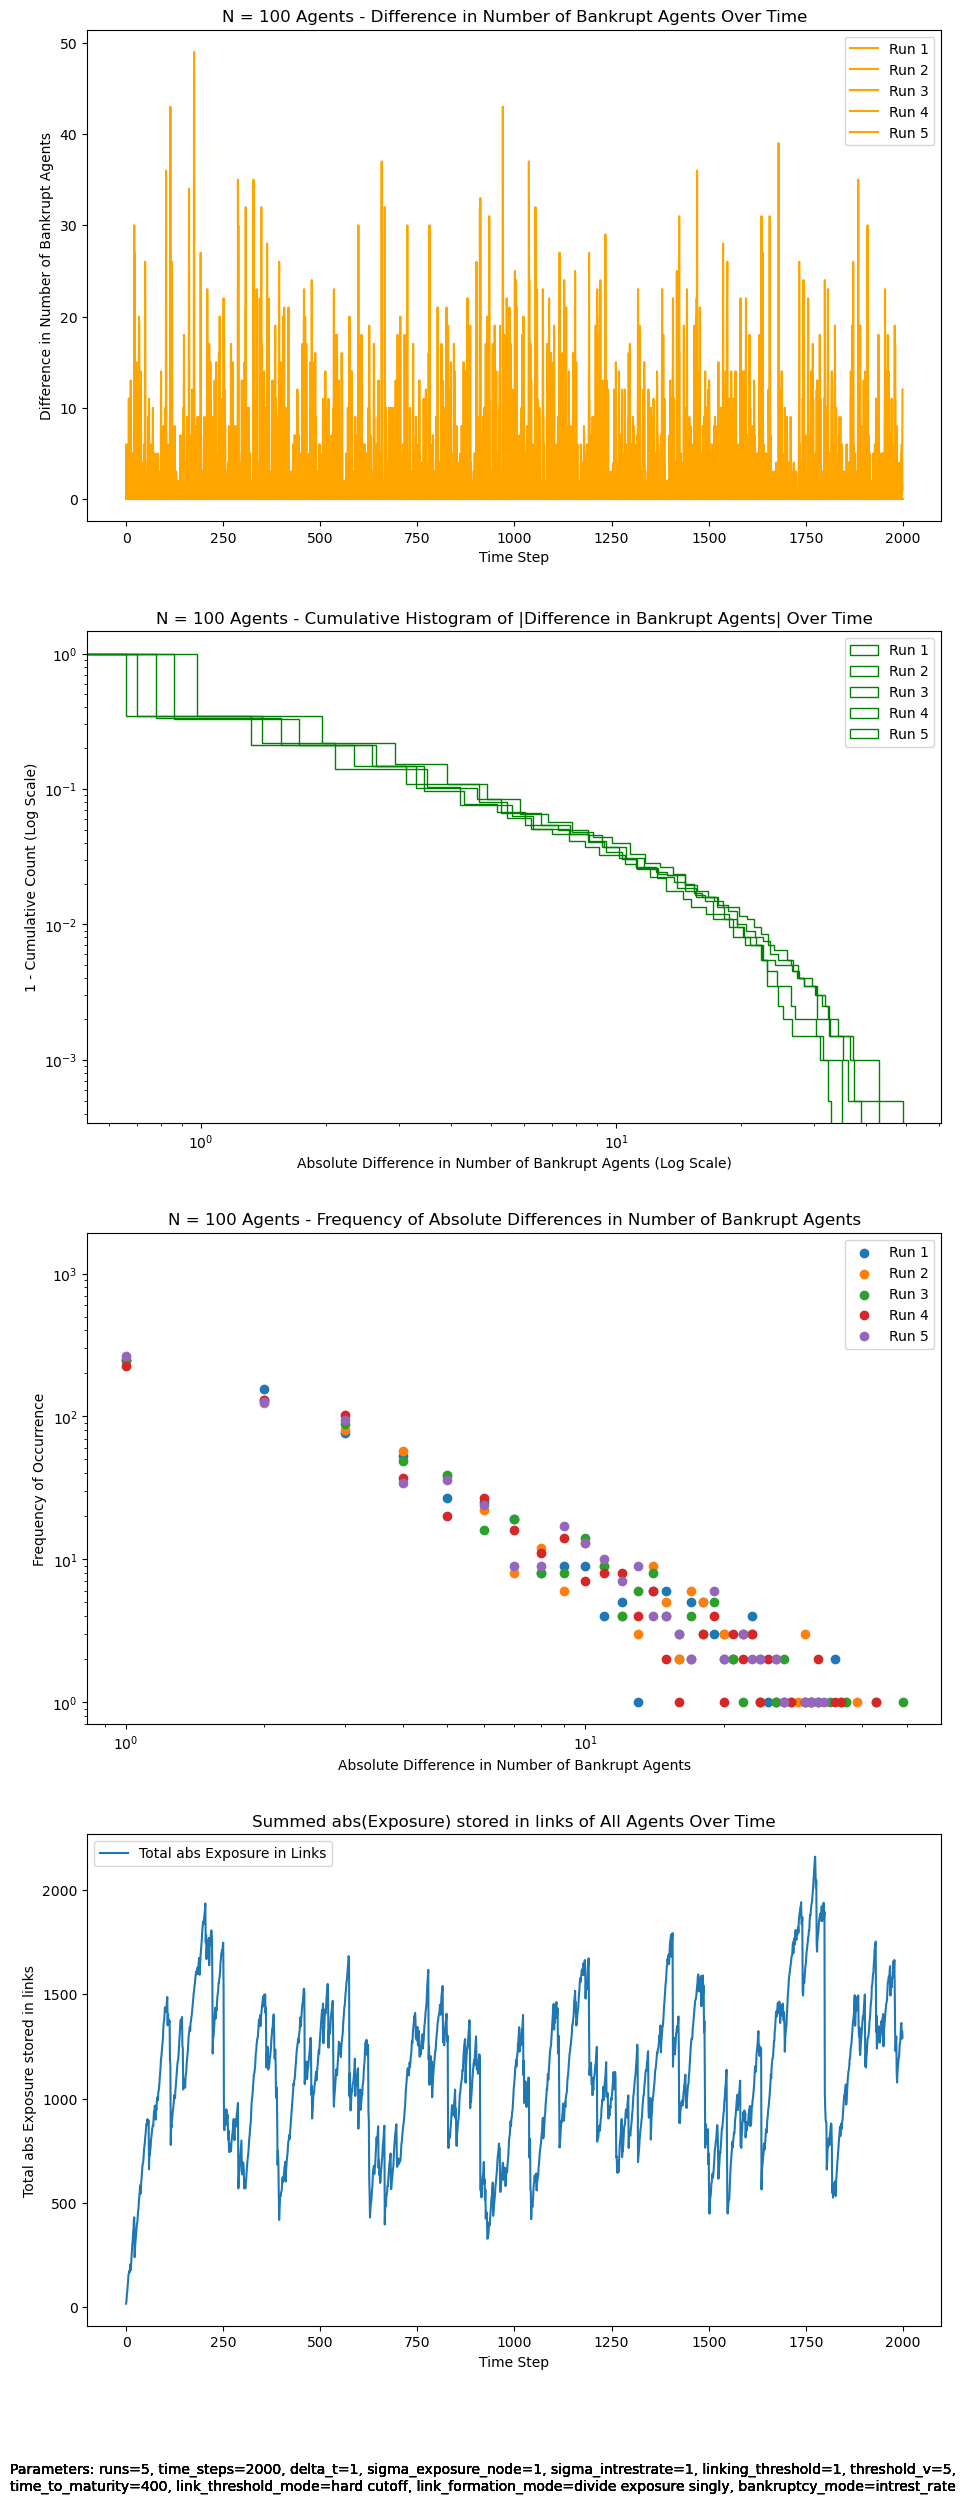

Results Summary for 200 Agents, run 1:
{'correlation': -0.1873281088871192, 'adf_statistic_ts1': -41.8286171447747, 'adf_pvalue_ts1': 0.0, 'adf_statistic_ts2': -4.466121254360943, 'adf_pvalue_ts2': 0.00022629558729762348, 'var_bic': 12.542375121950098, 'var_lag_order': 1, 'coint_rank': 1, 'cointegrating_eq_coefficients': array([[1.00000000e+00],
       [7.64316823e-04]]), 'adjustment_coefficients': array([[-0.9438405 ],
       [ 1.21291441]]), 'var_residuals_test': 0.0019337639493402406}

VECM Model Summary:
                 Loading coefficients (alpha) for equation y1                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1           -0.9438      0.023    -41.517      0.000      -0.988      -0.899
                 Loading coefficients (alpha) for equation y2                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------

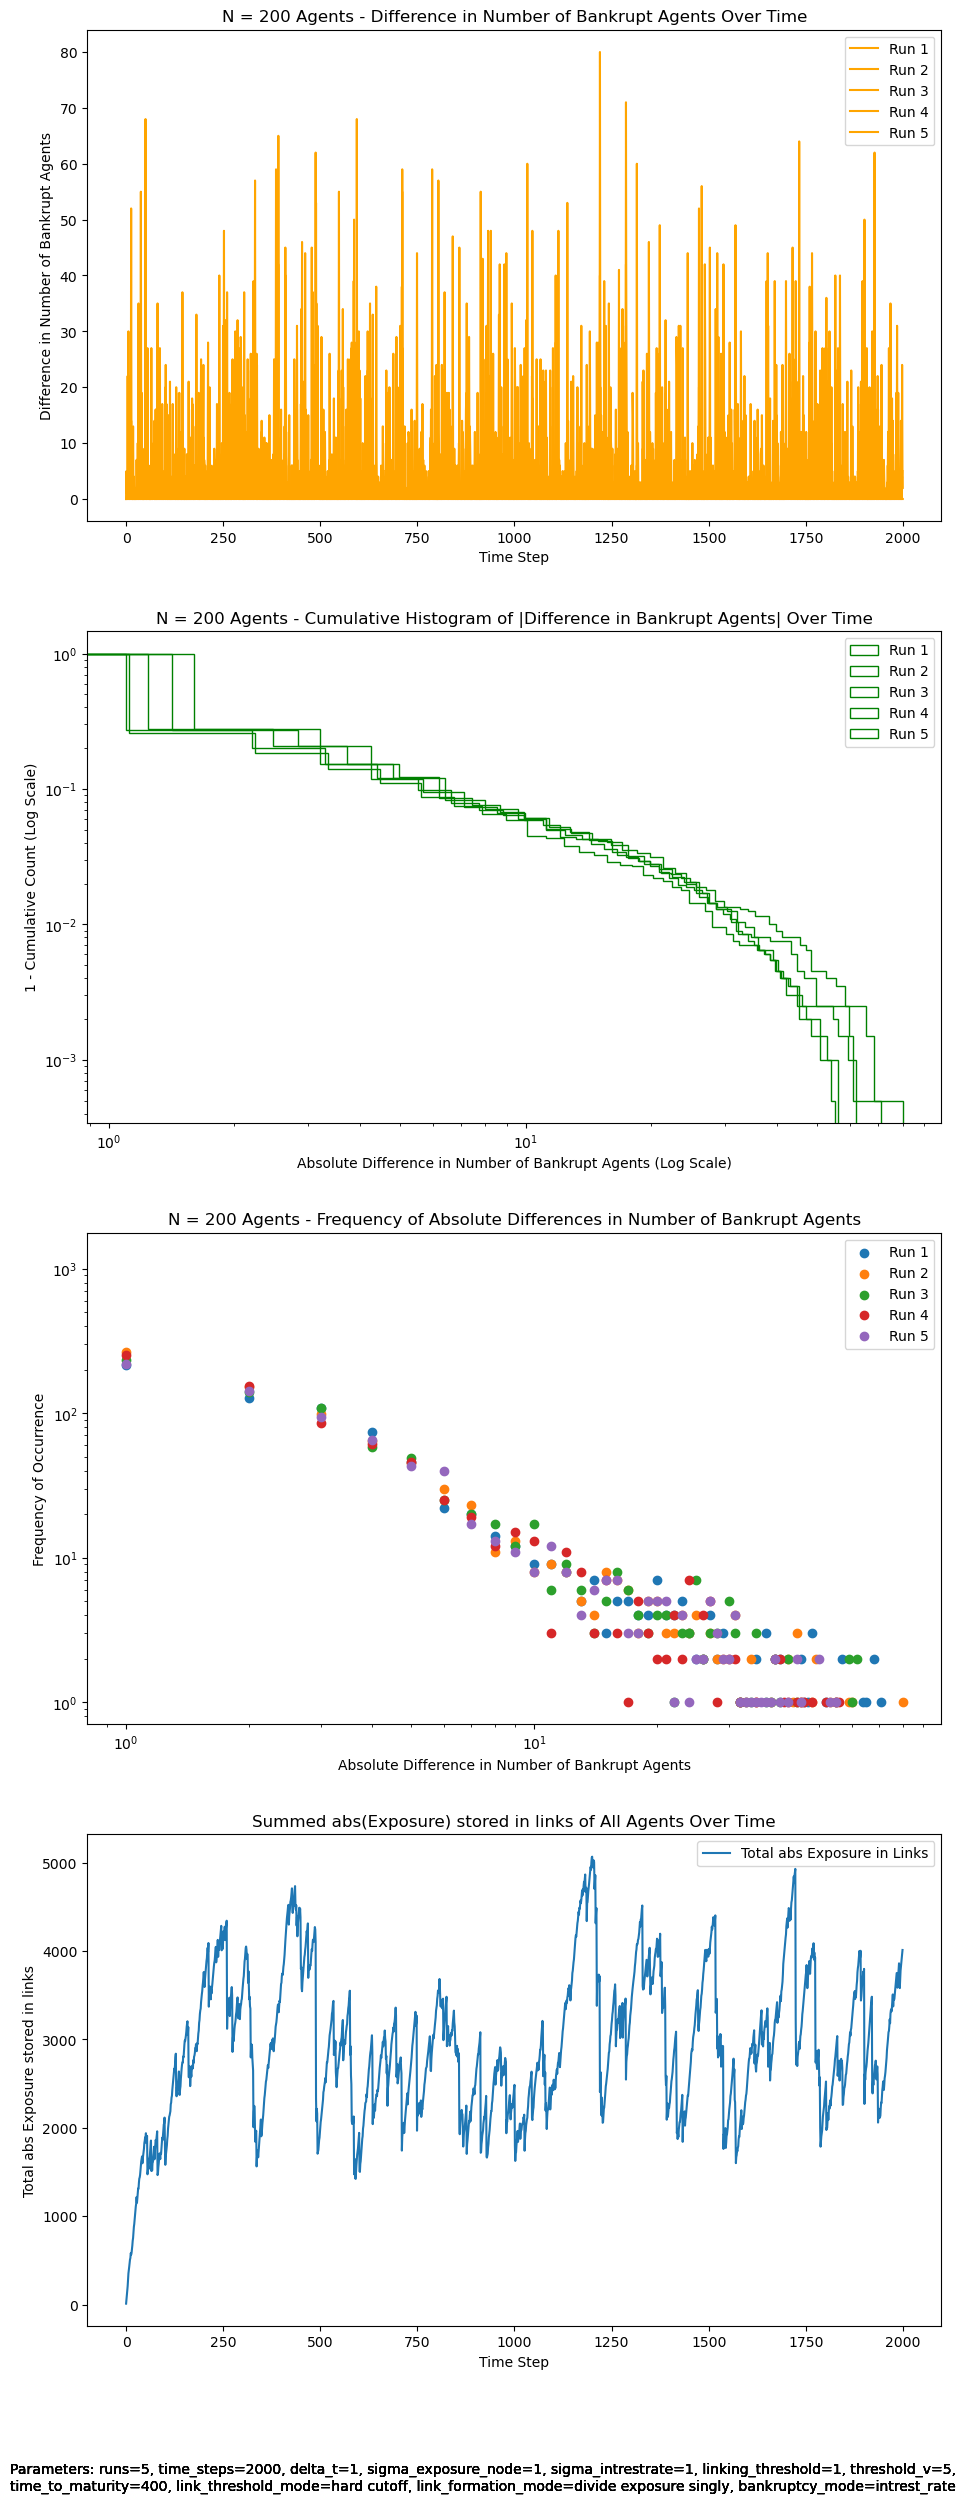

Results Summary for 300 Agents, run 1:
{'correlation': -0.17106719062454218, 'adf_statistic_ts1': -41.44371450159455, 'adf_pvalue_ts1': 0.0, 'adf_statistic_ts2': -4.454220427876599, 'adf_pvalue_ts2': 0.00023768670334538424, 'var_bic': 13.773077385267182, 'var_lag_order': 1, 'coint_rank': 1, 'cointegrating_eq_coefficients': array([[1.0000000e+00],
       [5.3447479e-04]]), 'adjustment_coefficients': array([[-0.93067538],
       [ 1.77531164]]), 'var_residuals_test': 0.0052718872911286475}

VECM Model Summary:
                 Loading coefficients (alpha) for equation y1                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1           -0.9307      0.023    -41.088      0.000      -0.975      -0.886
                 Loading coefficients (alpha) for equation y2                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------

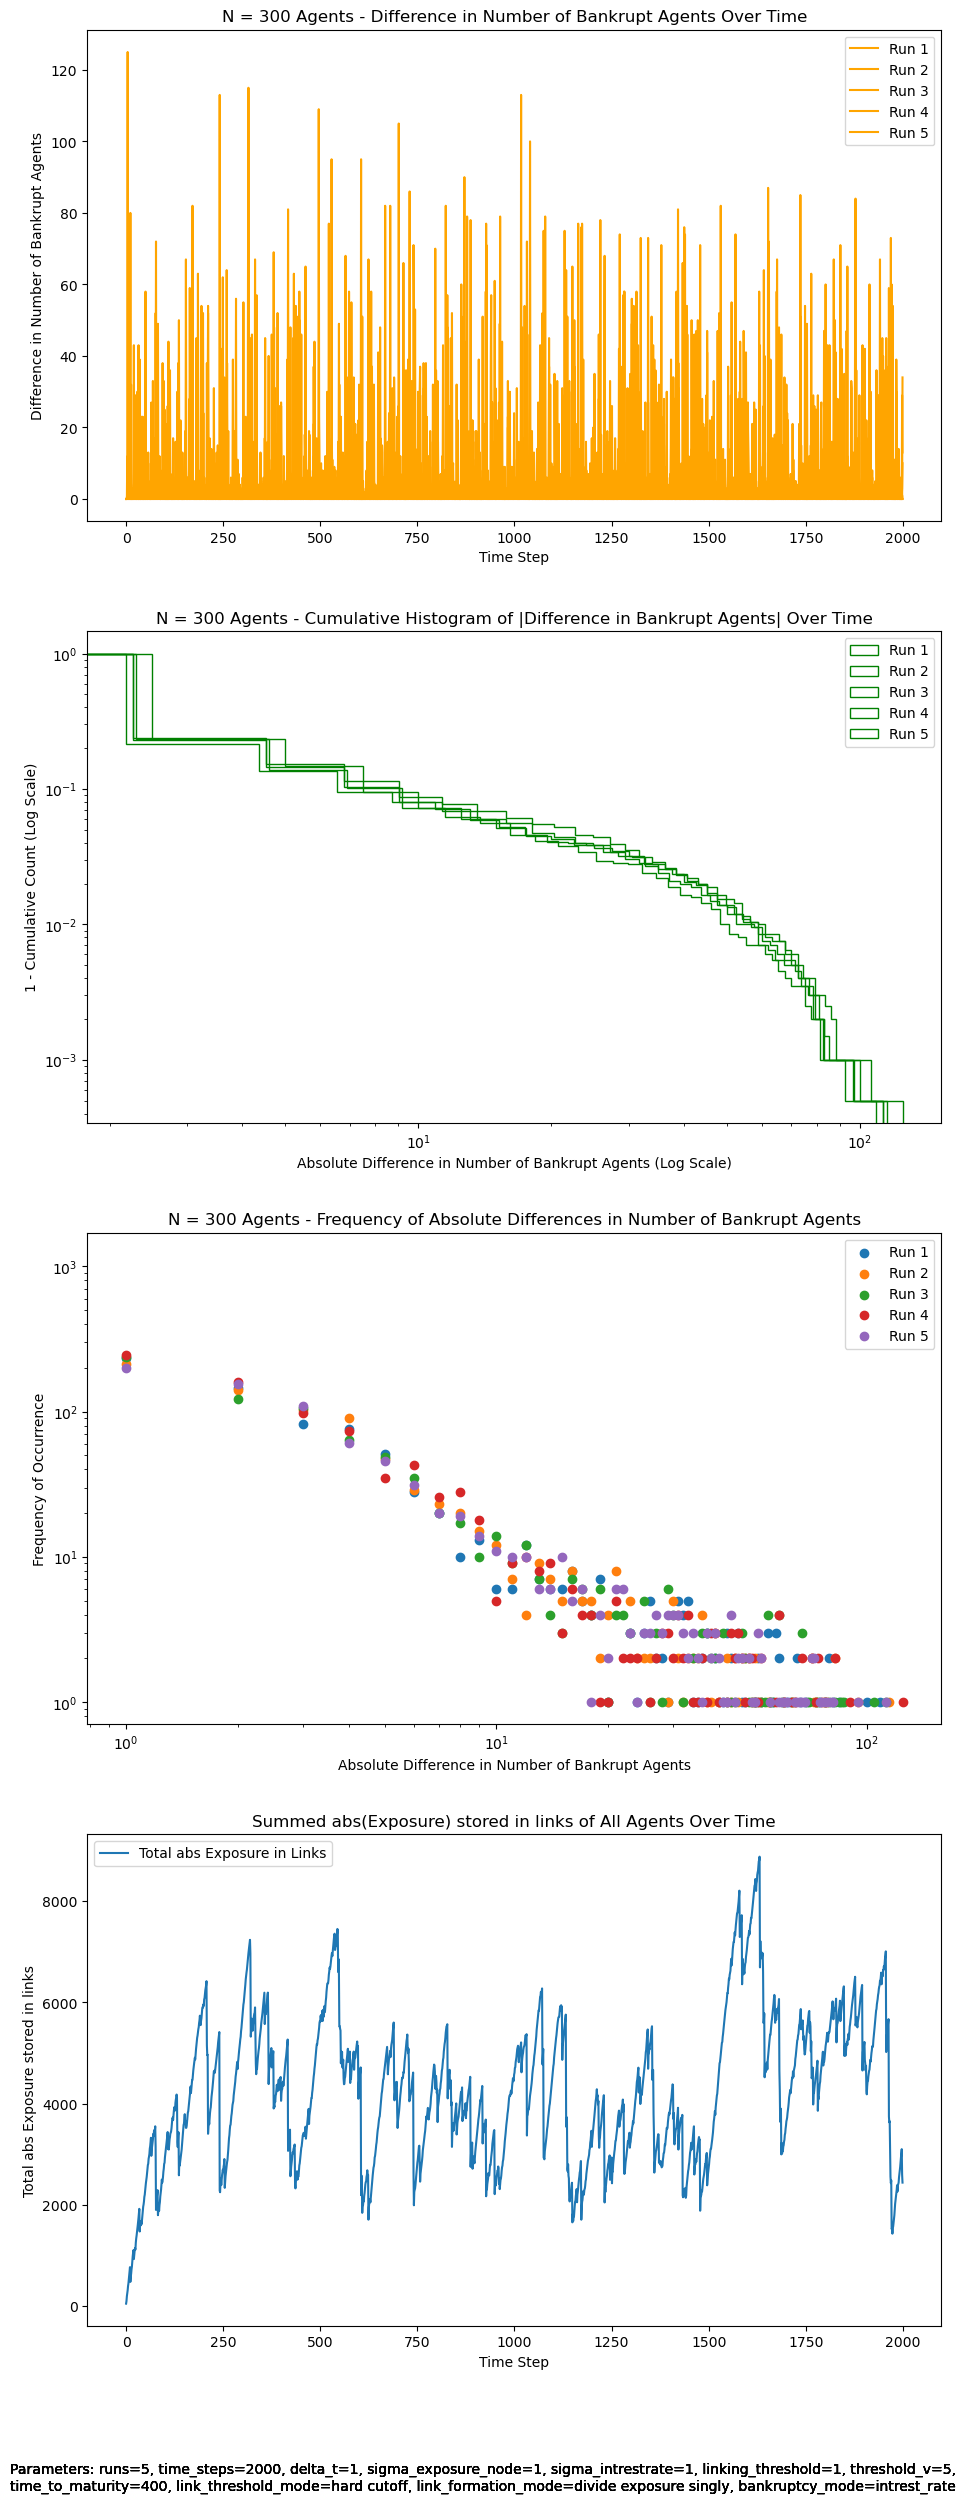

In [271]:
plot_bankruptcy_analysis_multiple_arrays(selected_files,  titles, param_caption)

\begin{table}
\centering
\caption{Organized Summary of Alpha and Beta Coefficients}
\begin{tabular}{|c|c|c|c|p{5cm}|}
\hline
\textbf{Run} & \textbf{Alpha Coefficients for y1} & \textbf{Alpha Coefficients for y2} & \textbf{Beta Coefficients} & \textbf{Interpretation} \\ \hline
1 & -0.7236 & -28.2984 & 1.0000, 5.418e-05 & The negative alpha coefficients suggest both variables adjust back to equilibrium, but the adjustment is significantly stronger for y2. The beta coefficient indicates for a unit increase in y1, y2 increases by a small fraction in the long term. \\ \hline
2 & -0.5340 & -49.2685 & 1.0000, 5.764e-05 & Similar to Run 1, both variables adjust towards equilibrium with a more substantial adjustment by y2. The beta coefficient shows a slightly larger long-term relationship effect than in Run 1. \\ \hline
3 & -0.8911 & -0.6677 & 1.0000, 4.529e-05 & Both variables adjust back to equilibrium; y1 adjusts more rapidly than y2. The beta indicates a long-term relationship where y2's increase is smaller per unit increase in y1 compared to Runs 1 and 2. \\ \hline
4 & -0.7676 & -14.0761 & 1.0000, 5.206e-05 & Both variables again adjust towards equilibrium, with y2 showing a substantial but lesser adjustment compared to Run 2. The beta coefficient's long-term relationship effect is between that of Runs 1 and 2. \\ \hline
5 & -1.1654 & 33.4850 & 1.0000, 5.100e-05 & Here, y1 adjusts towards equilibrium more aggressively, while y2's positive coefficient suggests a diverging or incorrect model specification. The beta coefficient indicates a long-term relationship similar to Run 4. \\ \hline
\end{tabular}
\end{table}

Alpha Coefficients


Significance: The alpha coefficients measure the speed at which variables adjust back to the equilibrium after a shock. Significant alpha coefficients (with p-values less than a typical threshold of 0.05) indicate that the variable in question significantly adjusts towards long-term equilibrium. In the context provided:
For y1, alpha coefficients are significantly negative across all runs (except possibly in Run 5 where the adjustment direction for y2 is positive, indicating a potential model mis-specification or an anomaly). This consistent significance suggests that y1 quickly responds to deviations from equilibrium, moving to correct those deviations over time.
For y2, the significance varies across runs. The large magnitude and negative sign in Runs 1, 2, and 4 suggest a strong and significant adjustment towards equilibrium. However, Run 5 presents a significant positive alpha for y2, implying divergence from equilibrium, which is unusual and warrants further investigation.
Beta Coefficients


Significance: Beta coefficients represent the long-term relationship between the variables. A significant beta coefficient indicates a stable and meaningful equilibrium relationship that holds over the long term. The beta coefficients across all runs are significant, as evidenced by their reported standard errors and the context of their z-scores or t-stats (implied by the provided details):
The consistent beta coefficient values across runs highlight a stable and significant long-term relationship between y1 and y2. The small magnitude of the coefficients (in the range of e-05) suggests that the long-term impact of y1 on y2 is positive but minimal. The significance of these coefficients reinforces the existence of a cointegrating relationship, confirming that y1 and y2 do not drift apart in the long run.

In [272]:
def probability_of_default(data_array, threshold):
    return [1 if x > threshold else 0 for x in data_array]/len(data_array)

In [273]:
def fit_power_law_array(data_array, titles):
    """
    Fit data from multiple arrays to a power-law distribution and compare it with an exponential distribution.
    Includes an aggregated p-value using Stouffer's Z-method in its own row below the runs it aggregates.

    Parameters:
    data_array (List[pd.DataFrame]): List of pandas DataFrames with data to be fitted.
    titles (List[str]): List of titles corresponding to each DataFrame in data_array.

    Returns:
    pd.DataFrame: A DataFrame containing individual run data and aggregated p-values for each title.
    """
    results_list = []

    for file_index, file in enumerate(data_array):
        p_values = []
        for run in range(file.shape[0]):
            run_data = file.iloc[run]
            run_data = convert_string_to_list(run_data)

            # Fit the data to a power-law distribution
            results = powerlaw.Fit(run_data)
            alpha = results.power_law.alpha
            R, p = results.distribution_compare('power_law', 'exponential', normalized_ratio=True)
            p_values.append(p)


            # Format p-value with significance levels
            p_value_formatted = f"{np.round(p, 4)}"
            if p < 0.001:
                p_value_formatted += "***"  # Highly significant
            elif p < 0.01:
                p_value_formatted += "**"   # Very significant
            elif p < 0.05:
                p_value_formatted += "*"    # Significant

            # Add results to list
            results_list.append({
                'N agents (Nodes)': titles[file_index],
                'run': run + 1,
                'alpha exponent': alpha,
                'likelihood ratio': R,
                'p-value': p_value_formatted
            })

            # Aggregate p-values for this title using Stouffer's Z-method from statsmodels
            combined_test_stat, aggregated_p_value = combine_pvalues(p_values, method='stouffer')


            # Format aggregated_p_value p-value with significance levels
            aggregated_p_value_formatted = f"{np.round(aggregated_p_value, 4)}"
            if aggregated_p_value < 0.001:
                aggregated_p_value_formatted += "***"  # Highly significant
            elif aggregated_p_value < 0.01:
                aggregated_p_value_formatted += "**"   # Very significant
            elif aggregated_p_value < 0.05:
                aggregated_p_value_formatted += "*"    # Significant



        results_list.append({
            'N agents (Nodes)': '',
            'run': 'Stouffer’s p-value',
            'alpha exponent': '',
            'likelihood ratio': '',
            'p-value': aggregated_p_value_formatted
        })

    # Create DataFrame for all results
    results_df = pd.DataFrame(results_list)
    return results_df

In [274]:
fit_power_law_array(data_our_model_bankruptcy, titles)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

,N agents (Nodes),run,alpha exponent,likelihood ratio,p-value
0,100 Agents,1,2.582411,2.253132,0.0243*
1,100 Agents,2,2.495865,4.384189,0.0***
2,100 Agents,3,4.170634,-0.14068,0.8881
3,100 Agents,4,2.824595,-0.817323,0.4137
4,100 Agents,5,3.504318,0.322458,0.7471
5,,Stouffer’s p-value,,,0.0212*
6,200 Agents,1,2.229182,7.322882,0.0***
7,200 Agents,2,2.215366,5.920257,0.0***
8,200 Agents,3,2.239663,5.87563,0.0***
9,200 Agents,4,2.25435,5.218964,0.0***


# Papers model

In [275]:
path = R'C:\Users\nitai\OneDrive\MScCLS\Complex system simulation\FinancialNetwork\Data papers model'


In [276]:
# 200_2000_1_2_1_5_1_3_400_hard cutoff_random link logic_exposure_20240131155859

<!-- '2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate' -->

In [277]:
input_parameters = '2000_1_1_1_5_1_3_400_hard cutoff_random link logic_exposure'

# Get the matching files
selected_files = get_files_with_parameters(path, input_parameters)

data_paper = select_variable_given_list_of_dfs(selected_files, 'Abs Difference of Bankrupt Agents Over Time')

all files in directory:  ['100_2000_1_1_1_5_1_2_200_hard cutoff_random link logic_exposure_20240131085653.csv', '100_2000_1_1_1_5_1_2_400_hard cutoff_random link logic_exposure_20240131092225.csv', '100_2000_1_1_1_5_1_2_600_hard cutoff_random link logic_exposure_20240131092355.csv', '100_2000_1_1_1_5_1_3_400_hard cutoff_random link logic_exposure_20240131155444.csv', '100_2000_1_1_1_5_1_4_200_hard cutoff_random link logic_exposure_20240131092557.csv', '100_2000_1_1_1_5_1_4_400_hard cutoff_random link logic_exposure_20240131092859.csv', '100_2000_1_1_1_5_1_4_600_hard cutoff_random link logic_exposure_20240131094135.csv', '100_2000_1_1_1_5_1_8_200_hard cutoff_random link logic_exposure_20240131094411.csv', '100_2000_1_1_1_5_1_8_400_hard cutoff_random link logic_exposure_20240131094707.csv', '100_2000_1_1_1_5_1_8_600_hard cutoff_random link logic_exposure_20240131094958.csv', '100_2000_1_2_1_5_1_2_200_hard cutoff_random link logic_exposure_20240131095038.csv', '100_2000_1_2_1_5_1_2_400_ha

In [278]:
param_caption = { "runs": 5,
  "time_steps": 2000,
  "delta_t": 1,
  "sigma_exposure_node": 1,
  "sigma_intrestrate": 1,
  "linking_threshold": 1,
  "threshold_v": 5,
  "linking_threshold": 1,
  "time_to_maturity": 400,
  "link_threshold_mode": "hard cutoff",
  "link_formation_mode": '_random link logic',
  "bankruptcy_mode": "link logic_exposure",
}

Results Summary for 100 Agents, run 1:


{'correlation': -0.11204585473264012, 'adf_statistic_ts1': -15.565528767553346, 'adf_pvalue_ts1': 2.0171256654442955e-28, 'adf_statistic_ts2': -5.76237080960262, 'adf_pvalue_ts2': 5.633535535442162e-07, 'var_bic': 3.791450872356614, 'var_lag_order': 2, 'coint_rank': 1, 'cointegrating_eq_coefficients': array([[1.00000000e+00],
       [1.47736783e-04]]), 'adjustment_coefficients': array([[ -0.76417902],
       [-13.42536339]]), 'var_residuals_test': 0.029840511970380408}

VECM Model Summary:
Det. terms outside the coint. relation & lagged endog. parameters for equation y1
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y1         -0.1462      0.023     -6.478      0.000      -0.190      -0.102
L1.y2         -0.0018      0.001     -2.552      0.011      -0.003      -0.000
Det. terms outside the coint. relation & lagged endog. parameters for equation y2
                 coef    

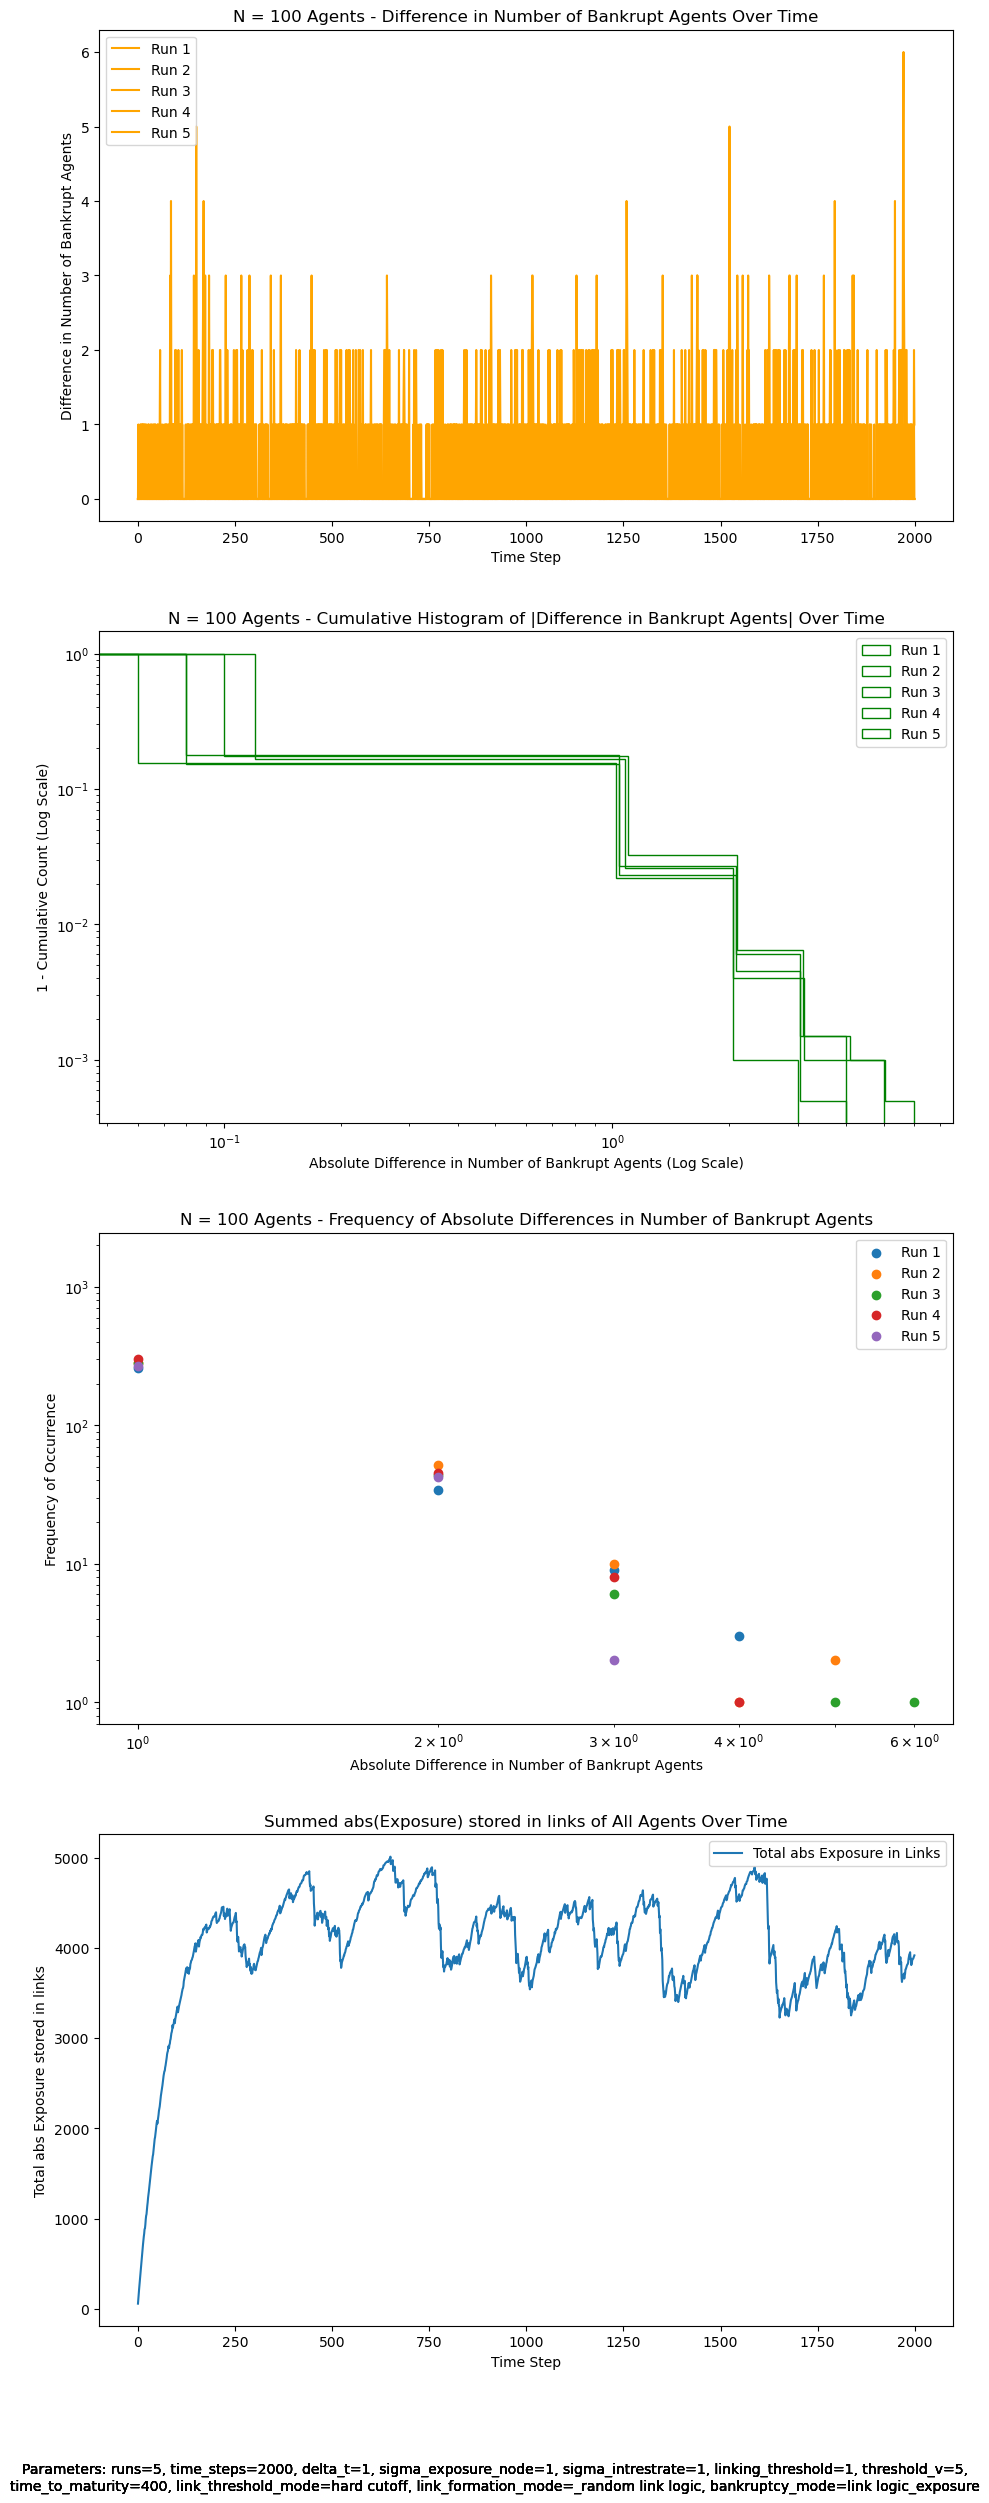

Results Summary for 200 Agents, run 1:
{'correlation': -0.04119110921442877, 'adf_statistic_ts1': -12.512972097392087, 'adf_pvalue_ts1': 2.6491723531754716e-23, 'adf_statistic_ts2': -5.408831237712103, 'adf_pvalue_ts2': 3.245500759212029e-06, 'var_bic': 5.539281129353715, 'var_lag_order': 2, 'coint_rank': 1, 'cointegrating_eq_coefficients': array([[1.00000000e+00],
       [5.41828182e-05]]), 'adjustment_coefficients': array([[ -0.72361207],
       [-28.29842214]]), 'var_residuals_test': 0.006417397623890588}

VECM Model Summary:
Det. terms outside the coint. relation & lagged endog. parameters for equation y1
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y1         -0.2050      0.023     -9.073      0.000      -0.249      -0.161
L1.y2         -0.0017      0.000     -3.570      0.000      -0.003      -0.001
Det. terms outside the coint. relation & lagged endog. parameters f

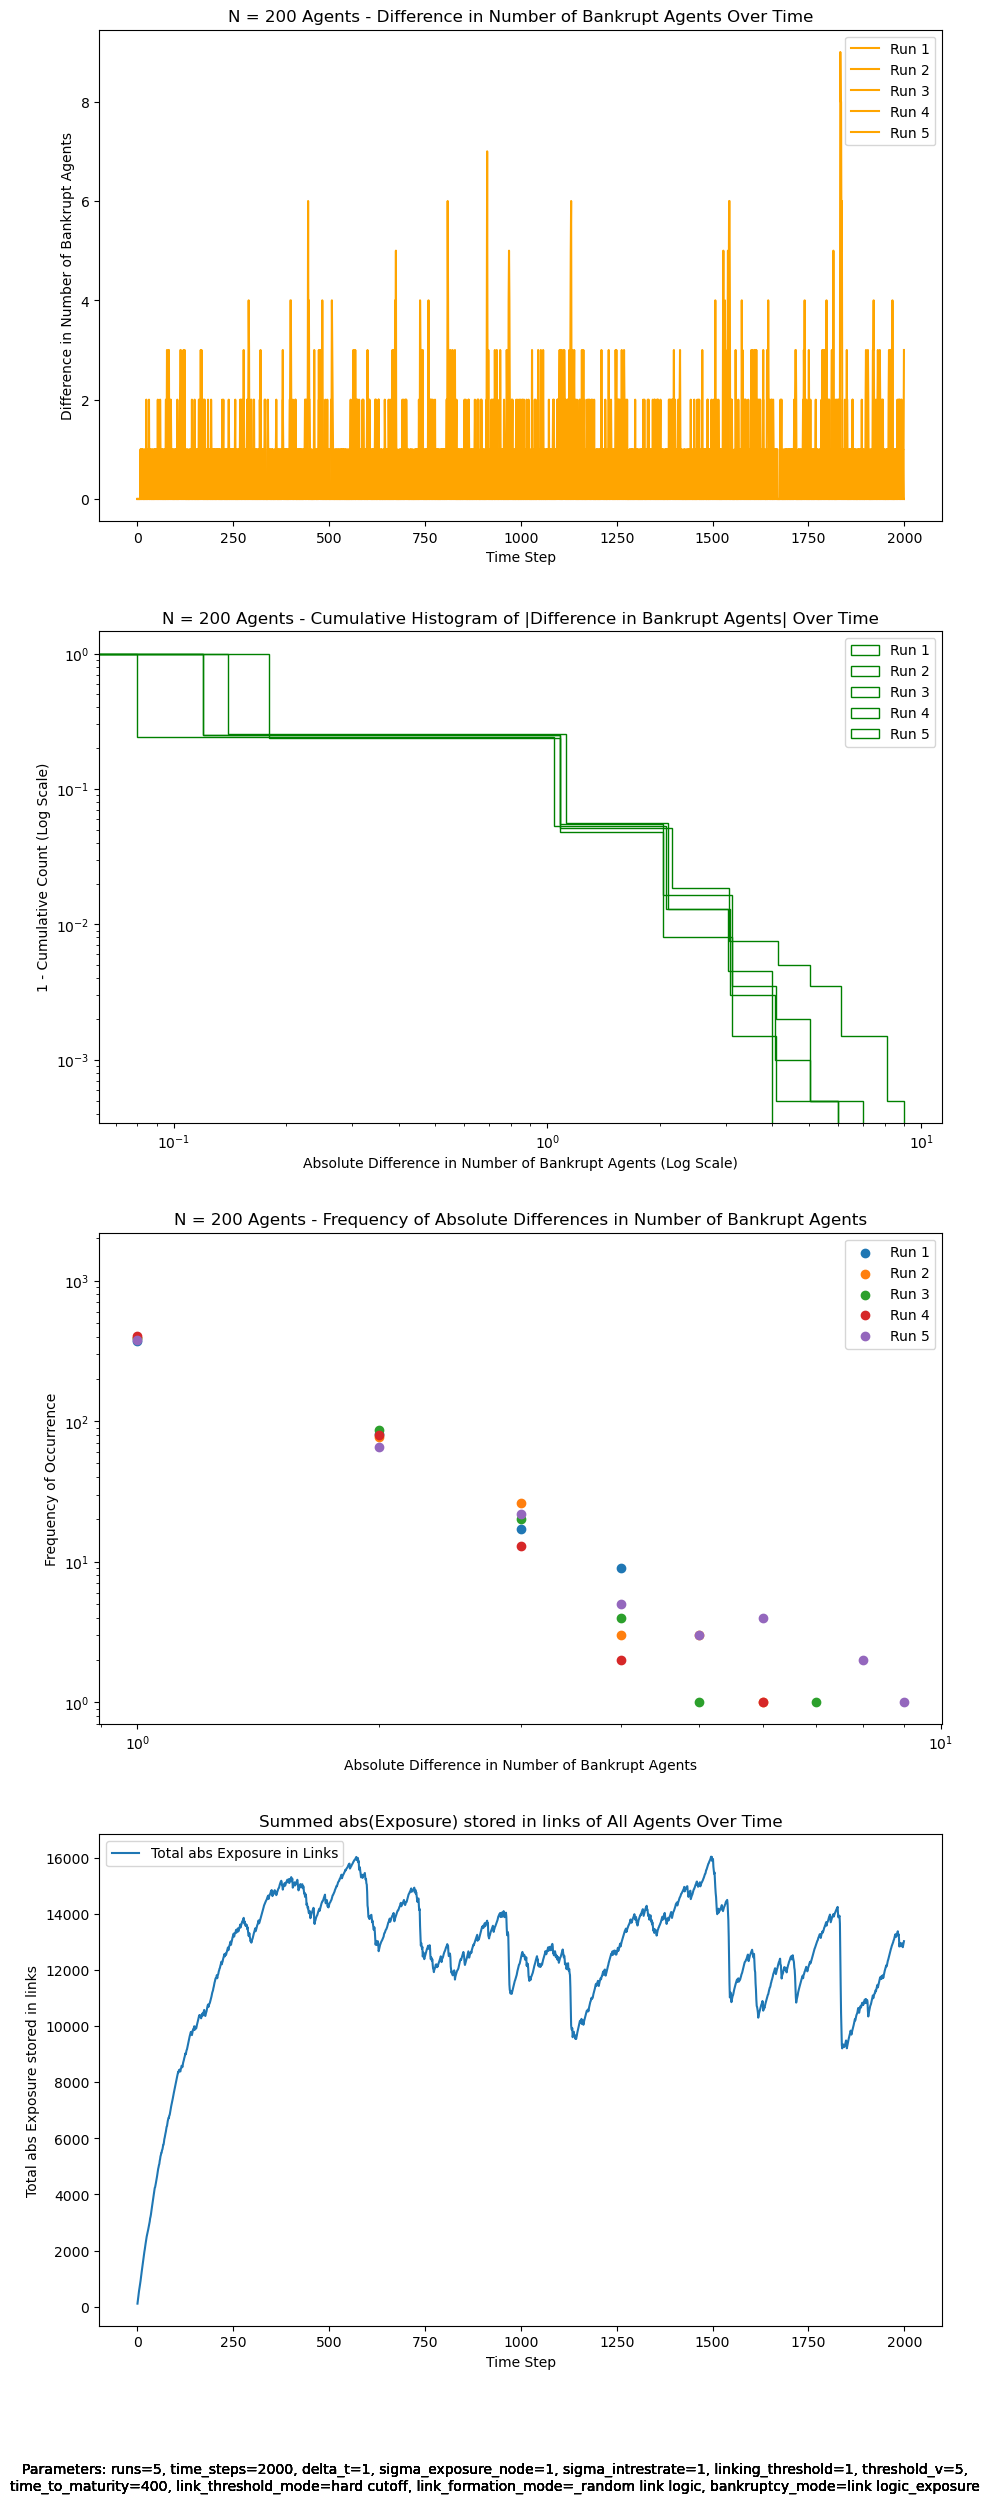

Results Summary for 300 Agents, run 1:
{'correlation': 0.01549355075205179, 'adf_statistic_ts1': -13.900253721398899, 'adf_pvalue_ts1': 5.75179751064648e-26, 'adf_statistic_ts2': -5.256827678791047, 'adf_pvalue_ts2': 6.723388716675215e-06, 'var_bic': 6.88560533161648, 'var_lag_order': 3, 'coint_rank': 1, 'cointegrating_eq_coefficients': array([[1.00000000e+00],
       [3.39278931e-05]]), 'adjustment_coefficients': array([[-0.82336789],
       [-9.53789028]]), 'var_residuals_test': 0.017447242446638055}

VECM Model Summary:
Det. terms outside the coint. relation & lagged endog. parameters for equation y1
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y1         -0.1431      0.067     -2.148      0.032      -0.274      -0.013
L1.y2         -0.0019      0.000     -4.741      0.000      -0.003      -0.001
L2.y1         -0.0933      0.023     -4.109      0.000      -0.138      -

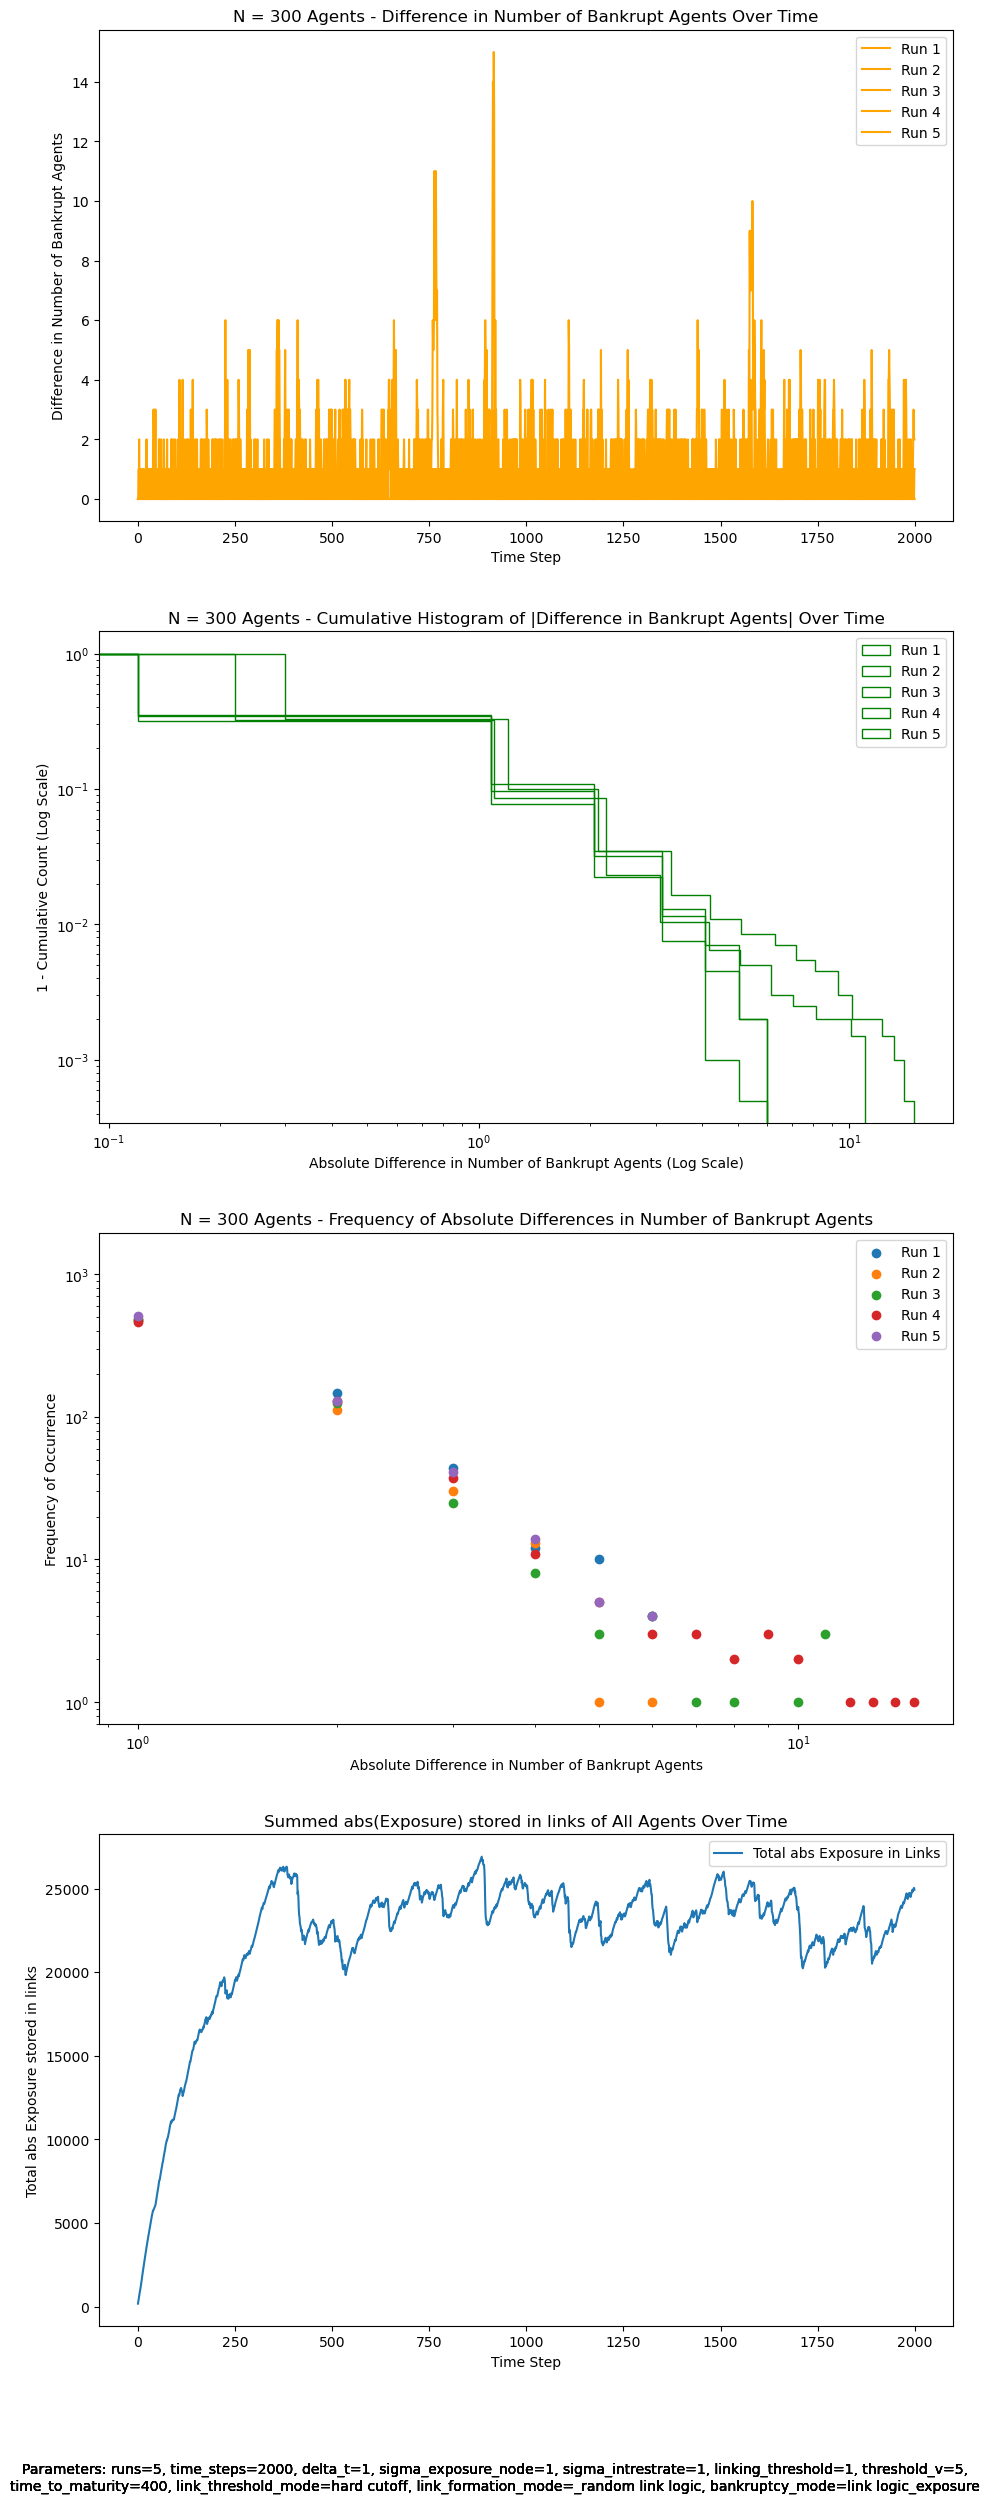

In [279]:
plot_bankruptcy_analysis_multiple_arrays(selected_files, titles, param_caption)

In [280]:
data_paper

[1    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
 2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
 4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 Name: Abs Difference of Bankrupt Agents Over Time, dtype: object,
 1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
 Name: Abs Difference of Bankrupt Agents Over Time, dtype: object,
 1    [0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 2    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...
 3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 4    [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...
 5    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...
 Name: Abs Difference of B

In [281]:
fit_power_law_array(data_paper, titles)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

,N agents (Nodes),run,alpha exponent,likelihood ratio,p-value
0,100 Agents,1,9.135399,13.067375,0.0***
1,100 Agents,2,10.928717,2.703785,0.0069**
2,100 Agents,3,12.691453,4.436069,0.0***
3,100 Agents,4,32.284535,3.826657,0.0001***
4,100 Agents,5,55.258676,15.012201,0.0***
5,,Stouffer’s p-value,,,0.0***
6,200 Agents,1,6.509864,14.617672,0.0***
7,200 Agents,2,11.684209,4.424535,0.0***
8,200 Agents,3,8.665191,1.506681,0.1319
9,200 Agents,4,13.377589,4.573385,0.0***


# Plot 2: Our model

In [282]:
path = R'C:\Users\nitai\OneDrive\MScCLS\Complex system simulation\FinancialNetwork\Data our model'

input_parameters_paper = '2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate'

selected_files_paper = get_files_with_parameters(path, input_parameters_paper)

data_plot_2_our_model_diff_agents = select_variable_given_list_of_dfs(selected_files_paper, 'Abs Difference of Bankrupt Agents Over Time')
data_plot_2_our_model_num_agents = select_variable_given_list_of_dfs(selected_files_paper, 'Number of Bankrupt Agents Over Time')

all files in directory:  ['100_2000_1_1_1_5_1_3_200_hard cutoff_divide exposure singly_intrest_rate_20240131000358.csv', '100_2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240131000537.csv', '100_2000_1_1_1_5_1_3_600_hard cutoff_divide exposure singly_intrest_rate_20240131000716.csv', '100_2000_1_2_1_5_1_3_200_hard cutoff_divide exposure singly_intrest_rate_20240131000851.csv', '100_2000_1_2_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240131001028.csv', '100_2000_1_2_1_5_1_3_600_hard cutoff_divide exposure singly_intrest_rate_20240131001205.csv', '100_2000_1_4_1_5_1_3_200_hard cutoff_divide exposure singly_intrest_rate_20240131001336.csv', '100_2000_1_4_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240131001508.csv', '100_2000_1_4_1_5_1_3_600_hard cutoff_divide exposure singly_intrest_rate_20240131001640.csv', '100_200_1_1_1_2_2_2_1_hard cutoff_divide exposure singly_exposure_20240130232202.csv', '100_200_1_1_1_2_2_2_1_hard cut

In [283]:
def perform_regression(dependent_var, *independent_vars):
    """
    Perform linear regression (simple or multiple) based on the number of independent variables provided.

    Parameters:
    dependent_var (array-like): The dependent variable.
    independent_vars (variable number of array-like): The independent variable(s).

    Returns:
    RegressionResults: The results of the regression analysis.
    """
    # Combine independent variables into a DataFrame
    data = pd.DataFrame({f'var{i}': var for i, var in enumerate(independent_vars, start=1)})

    # Add the dependent variable
    data['dependent'] = dependent_var

    # Define the formula
    independent = ' + '.join(data.columns[:-1])
    formula = f'dependent ~ {independent}'

    # Fit the model
    model = sm.OLS.from_formula(formula, data).fit()

    return model.summary()

In [284]:
def compare_group_means(*groups):
    """
    Compare means of multiple groups using ANOVA or Kruskal-Wallis test.
    Includes a conclusion based on the hypothesis test.
    """
    # Check for zero variance within each group
    if any(np.ptp(group) == 0 for group in groups):
        print("One or more groups have zero variance, performing non-parametric Kruskal-Wallis test.")
        kruskal_result = stats.kruskal(*groups)
        conclusion = "There is no significant difference between the groups." if kruskal_result.pvalue > 0.05 else "There is a significant difference between the groups."
        return f"Kruskal-Wallis Test Result:\nH-statistic: {kruskal_result.statistic}\nP-value: {kruskal_result.pvalue}\nConclusion: {conclusion}"

    # Create a DataFrame to hold all groups data
    group_labels = [f'group{i+1}' for i in range(len(groups))]
    data_values = []
    data_groups = []
    for i, group in enumerate(groups):
        data_values.extend(group)
        data_groups.extend([group_labels[i]] * len(group))
    
    df = pd.DataFrame({'value': data_values, 'group': data_groups})

    # Checking for normality and homogeneity of variances
    normality_p_values = [stats.shapiro(df[df['group'] == group]['value']).pvalue for group in group_labels]
    normal = all(p > 0.05 for p in normality_p_values)
    homogeneity_p_value = stats.levene(*groups).pvalue
    homogeneous = homogeneity_p_value > 0.05

    if normal and homogeneous:
        print("The data is normal and homogeneous, performing ANOVA.")
        # Perform ANOVA
        model = ols('value ~ C(group)', data=df).fit()
        anova_result = sm.stats.anova_lm(model, typ=2)
        conclusion = "There is no significant difference between the groups." if anova_result['PR(>F)'].iloc[0] > 0.05 else "There is a significant difference between the groups."
        return f"ANOVA Result:\n{anova_result}\nConclusion: {conclusion}"
    else:
        print("The data is not normal and/or not homogeneous, performing non-parametric Kruskal-Wallis test.")
        # Perform Kruskal-Wallis Test
        kruskal_result = stats.kruskal(*groups)
        conclusion = "There is no significant difference between the groups." if kruskal_result.pvalue > 0.05 else "There is a significant difference between the groups."
        return f"Kruskal-Wallis Test Result:\nH-statistic: {kruskal_result.statistic}\nP-value: {kruskal_result.pvalue}\nConclusion: {conclusion}"

In [285]:
def is_default(bankrupt_agents, threshold, system_size):
    return bankrupt_agents >= threshold * system_size

def calculate_default_probability(bankrupt_agents_list, threshold, system_size):
    defaults = [is_default(ba, threshold, system_size) for ba in bankrupt_agents_list]
    num_defaults = sum(defaults)
    default_probability = num_defaults / len(bankrupt_agents_list) if len(bankrupt_agents_list) > 0 else 0
    return default_probability, num_defaults

In [286]:
def plot_default_size(data_array_num, data_array_diff, titles, system_sizes, default_consideration_threshold):
    all_data = {}  # Dictionary to store default probabilities for each system size

    # Iterate over each system size and its corresponding data
    for file_index, (num_file, diff_file, title, system_size) in enumerate(zip(data_array_num, data_array_diff, titles, system_sizes)):

        # List to store default probabilities for this system size
        default_probabilities = []

        # Iterate over each run in the dataset
        for run in range(diff_file.shape[0]):
            # Extract and convert the difference of bankrupt agents for each run
            diff_bankrupt_agents = convert_string_to_list(diff_file.iloc[run])

            if diff_bankrupt_agents:
                # Calculate the default probability for this run
                default_probability, num_defaults = calculate_default_probability(diff_bankrupt_agents, default_consideration_threshold, system_size)
                default_probabilities.append(default_probability)

        # Store the default probabilities for this system size
        all_data[system_size] = default_probabilities

    # Conduct the statistical test using the default probabilities
    test_result_with_conclusion = compare_group_means(*all_data.values())
    print(test_result_with_conclusion)  # This will print the result to the notebook

    # Creating box plots
    plt.figure(figsize=(10, 6))
    plt.boxplot(all_data.values(), labels=[f'N={size}' for size in all_data.keys()])
    plt.xlabel('System Size')
    plt.ylabel('Default Probability')
    plt.title('Box Plot of Default Probability per System Size')
    plt.grid(True)
    plt.show()

In [287]:
def plot_default_size_dot(data_array_num, data_array_diff, titles, system_sizes, default_consideration_threshold=0.1):
    plt.figure(figsize=(10, 6))

    # Data structure to hold default probabilities for each system size
    default_probs_data = {size: [] for size in system_sizes}

    # Scatter plot data
    scatter_data_x = []
    scatter_data_y = []

    for file_index, (num_data, diff_data, title, size) in enumerate(zip(data_array_num, data_array_diff, titles, system_sizes)):
        for run_index, diff_str in enumerate(diff_data):
            diff_bankrupt_agents = convert_string_to_list(diff_str)
            default_probability, _ = calculate_default_probability(diff_bankrupt_agents, default_consideration_threshold, size)
            default_probs_data[size].append(default_probability)

            # Collect data for scatter plot
            scatter_data_x.append(size)
            scatter_data_y.append(default_probability)

    # Group default probabilities by system size
    grouped_default_probs = [default_probs_data[size] for size in system_sizes]

    # Performing the statistical test and printing the result
    test_result = compare_group_means(*grouped_default_probs)
    print(test_result)  # This will print the result to the notebook

    # Plot individual runs with larger dots
    plt.scatter(scatter_data_x, scatter_data_y, s=50, alpha=0.75, edgecolors='w', linewidths=0.5)  # Increased dot size

    # Error bars for mean and standard deviation
    for size in system_sizes:
        mean_prob = np.mean(default_probs_data[size])
        std_prob = np.std(default_probs_data[size])
        plt.errorbar(size, mean_prob, yerr=std_prob, fmt='o', color='red', capsize=5, label='Mean with 1 Std.' if size == system_sizes[0] else "")

    # Formatting the plot
    plt.xlabel('System Size')
    plt.ylabel('Default Probability')
    plt.title('Default Probability per System Size with Standard Deviation')
    plt.legend()
    plt.grid(True)
    plt.show()

In [292]:
system_sizes = [100, 200, 300]

One or more groups have zero variance, performing non-parametric Kruskal-Wallis test.
Kruskal-Wallis Test Result:
H-statistic: 8.227360308285164
P-value: 0.016347502360354576
Conclusion: There is a significant difference between the groups.


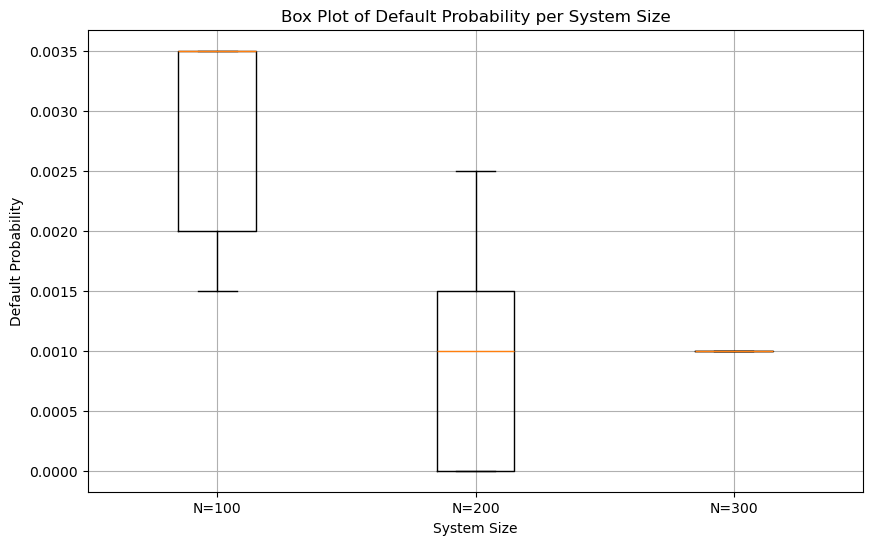

In [293]:
# set default threshold
default_consideration_threshold = 0.3
plot_default_size(data_array_num = data_plot_2_our_model_num_agents, data_array_diff=data_plot_2_our_model_diff_agents,titles=titles,system_sizes=system_sizes,  default_consideration_threshold=default_consideration_threshold)

One or more groups have zero variance, performing non-parametric Kruskal-Wallis test.
Kruskal-Wallis Test Result:
H-statistic: 8.227360308285164
P-value: 0.016347502360354576
Conclusion: There is a significant difference between the groups.


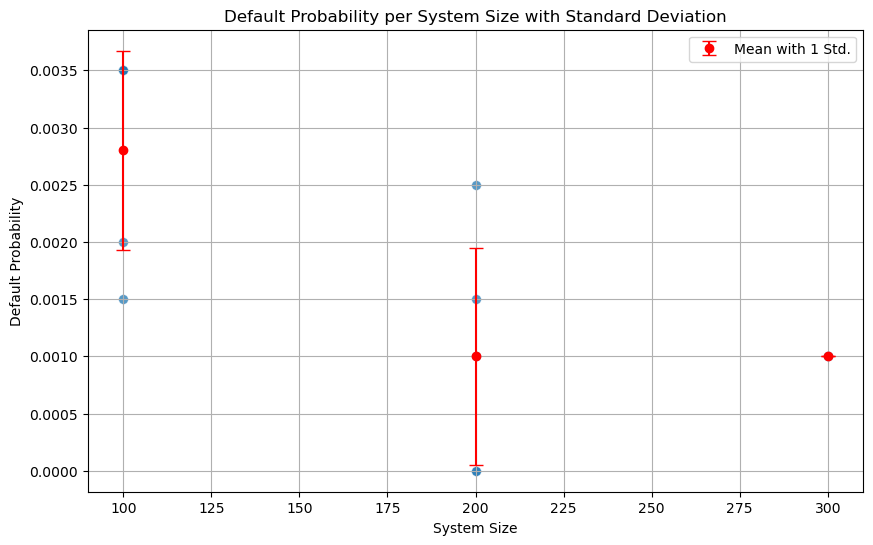

In [294]:
plot_default_size_dot(data_array_num = data_plot_2_our_model_num_agents, data_array_diff=data_plot_2_our_model_diff_agents,titles=titles,system_sizes=system_sizes, default_consideration_threshold=default_consideration_threshold)

# Plot 2: papers model

# Plot 3

In [295]:
directory_path = R'.\Data groupmates\Varying sigma\interest'
all_items = os.listdir(directory_path)

In [296]:
# def is_default(bankrupt_agents, threshold, system_size):
#     return bankrupt_agents >= threshold * system_size

# def calculate_default_probability(bankrupt_agents_list, threshold, system_size):
#     defaults = [is_default(ba, threshold, system_size) for ba in bankrupt_agents_list]
#     num_defaults = sum(defaults)
#     default_probability = num_defaults / len(bankrupt_agents_list) if len(bankrupt_agents_list) > 0 else 0
#     return default_probability, num_defaults

In [297]:
def calculate_default_probability(num_list, threshold = 0.6):
    nums = len([i for i in num_list if i >= threshold])
    return nums / len(num_list)

def group_files(directory: str = './', mode:str = 'sigma_interest_rates'):
    grouped_files = {}
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            parts = filename.split('_')
            if mode == 'sigma_interest_rates':
                key = tuple(parts[:4] + parts[5:-1])
                if key not in grouped_files:
                    grouped_files[key] = {'filenames': [], 'sigma_interest_rates': []}
                grouped_files[key]['filenames'].append(filename)
                grouped_files[key]['sigma_interest_rates'].append(parts[4])
            if mode == 'sigma_exposure_node':
                key = tuple(parts[:3] + parts[4:-1])
                if key not in grouped_files:
                    grouped_files[key] = {'filenames': [], 'sigma_exposure_node': []}
                grouped_files[key]['filenames'].append(filename)
                grouped_files[key]['sigma_exposure_node'].append(parts[3])
    return grouped_files

In [298]:
def plot_avalanche_prob_vs_volatility(directory:str = './', threshold = 10, mode:str = 'sigma_interest_rates'):
    
    groups = group_files(directory, mode)

    for key, value in groups.items():
        print("Key:", key)
        bankrupt_nodes_list = []
        filenames = value['filenames']
        for filename in filenames:
            full_path = os.path.join(directory, filename)
            df = pd.read_csv(full_path)
            bankrupt_nodes = []
            for i in range(len(df)):
                if pd.isna(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]) or pd.isna(df['Number of Bankrupt Agents Over Time'].iloc[i]):
                    continue
                else: 
                    bankrupt_node = calculate_default_probability(ast.literal_eval(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]), threshold = threshold, system_size = system_size)[0]
                    bankrupt_nodes.append(bankrupt_node)
            bankrupt_nodes_list.append(bankrupt_nodes)

        if mode == 'sigma_interest_rates':
            sigmas = value['sigma_interest_rates']
        if mode == 'sigma_exposure_node':
            sigmas = value['sigma_exposure_node']
            
        combined = sorted(zip(sigmas, bankrupt_nodes_list))
        sigmas_sorted, bankrupt_nodes_list_sorted = zip(*combined)
        plt.figure(figsize=(10, 6))
        plt.boxplot(bankrupt_nodes_list_sorted, labels=sigmas_sorted)
        plt.xlabel(mode.replace('_', ' ').title())
        plt.ylabel('Default Prob')
        plt.title('Avalanche Prob vs. Volatility')
        plt.show()

In [299]:
def plot_avalanche_prob_vs_volatility(directory:str = './', threshold=10, mode:str='sigma_interest_rates'):
    groups = group_files(directory, mode)
    all_group_data = []  # This will store the bankruptcy nodes for all groups for ANOVA testing

    for key, value in groups.items():
        print("Key:", key)
        bankrupt_nodes_list = []
        filenames = value['filenames']
        for filename in filenames:
            full_path = os.path.join(directory, filename)
            df = pd.read_csv(full_path)
            bankrupt_nodes = []
            for i in range(len(df)):
                if pd.isna(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]) or pd.isna(df['Number of Bankrupt Agents Over Time'].iloc[i]):
                    continue
                else:
                    bankrupt_node = calculate_default_probability(ast.literal_eval(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]), threshold=threshold)
                    bankrupt_nodes.append(bankrupt_node)
            bankrupt_nodes_list.append(np.mean(bankrupt_nodes))  # Use mean probability for ANOVA

        if mode == 'sigma_interest_rates':
            sigmas = value['sigma_interest_rates']
        elif mode == 'sigma_exposure_node':
            sigmas = value['sigma_exposure_node']
            
        combined = sorted(zip(sigmas, bankrupt_nodes_list))
        sigmas_sorted, bankrupt_nodes_list_sorted = zip(*combined)
        plt.figure(figsize=(10, 6))
        plt.boxplot(bankrupt_nodes_list_sorted, labels=sigmas_sorted)
        plt.xlabel(mode.replace('_', ' ').title())
        plt.ylabel('Default Prob')
        plt.title('Avalanche Prob vs. Volatility')
        plt.show()

        # Add the list of bankrupt nodes to the all_group_data for ANOVA testing
        all_group_data.append([np.mean(group) for group in bankrupt_nodes_list_sorted])  # Flatten and mean for ANOVA

    # After collecting all the data, perform ANOVA testing
    print(compare_group_means(*all_group_data))

In [300]:
def plot_avalanche_prob_vs_volatility(directory: str = './', threshold=10, mode: str = 'sigma_interest_rates'):
    groups = group_files(directory, mode)

    for key, value in groups.items():
        print("Key:", key)
        bankrupt_nodes_list = []
        filenames = value['filenames']
        for filename in filenames:
            full_path = os.path.join(directory, filename)
            df = pd.read_csv(full_path)
            bankrupt_nodes = []
            for i in range(len(df)):
                if pd.isna(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]) or pd.isna(df['Number of Bankrupt Agents Over Time'].iloc[i]):
                    continue
                else: 
                    bankrupt_node = calculate_default_probability(ast.literal_eval(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]), threshold=threshold)
                    bankrupt_nodes.append(bankrupt_node)
            bankrupt_nodes_list.append(bankrupt_nodes)

        if mode == 'sigma_interest_rates':
            sigmas = value['sigma_interest_rates']
        if mode == 'sigma_exposure_node':
            sigmas = value['sigma_exposure_node']
            
        combined = sorted(zip(sigmas, bankrupt_nodes_list))
        sigmas_sorted, bankrupt_nodes_list_sorted = zip(*combined)
        plt.figure(figsize=(10, 6))
        plt.boxplot(bankrupt_nodes_list_sorted, labels=sigmas_sorted)
        plt.xlabel(mode.replace('_', ' ').title())
        plt.ylabel('Default Prob')
        plt.title('Avalanche Prob vs. Volatility for ' + str(key))
        
        # Now we perform the ANOVA test
        if len(bankrupt_nodes_list_sorted) >= 2:  # Ensure there are at least 23 groups for ANOVA
            anova_results = compare_group_means(*bankrupt_nodes_list_sorted)
            print(anova_results)
        
        plt.show()

Key: ('100', '2000', '1', '1', '5', '1', '3', '400', 'hard cutoff', 'divide exposure singly', 'intrest', 'rate')
The data is normal and homogeneous, performing ANOVA.
ANOVA Result:
            sum_sq    df            F        PR(>F)
C(group)  0.280653   2.0  7356.564439  2.929091e-19
Residual  0.000229  12.0          NaN           NaN
Conclusion: There is a significant difference between the groups.


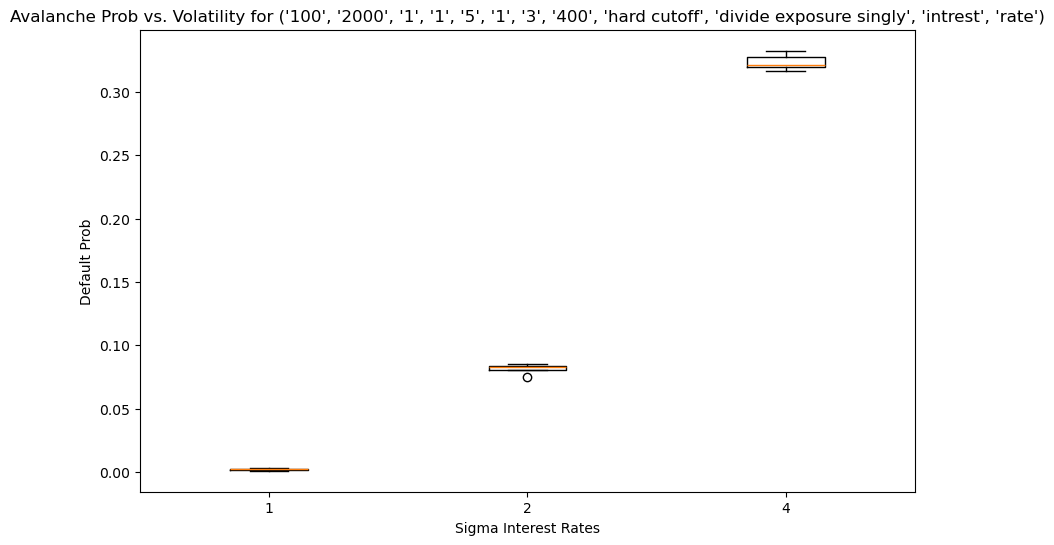

In [301]:
plot_avalanche_prob_vs_volatility(directory = directory_path, threshold = 30, mode='sigma_interest_rates')

In [302]:
directory_path = R'.\Data groupmates\Varying sigma\exposure'
all_items = os.listdir(directory_path)

In [303]:
all_items

['.DS_Store',
 '100_2000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240131154120.csv',
 '100_2000_1_1_1_5_1_3_400_hard cutoff_random link logic_exposure_20240131153753.csv',
 '100_2000_1_2_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240131154343.csv',
 '100_2000_1_2_1_5_1_3_400_hard cutoff_random link logic_exposure_20240131153813.csv',
 '100_2000_1_4_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240131154600.csv',
 '100_2000_1_4_1_5_1_3_400_hard cutoff_random link logic_exposure_20240131153821.csv']

Key: ('100', '2000', '1', '1', '5', '1', '3', '400', 'hard cutoff', 'divide exposure singly', 'intrest', 'rate')
The data is not normal and/or not homogeneous, performing non-parametric Kruskal-Wallis test.
Kruskal-Wallis Test Result:
H-statistic: 12.544802867383513
P-value: 0.0018876899735039802
Conclusion: There is a significant difference between the groups.


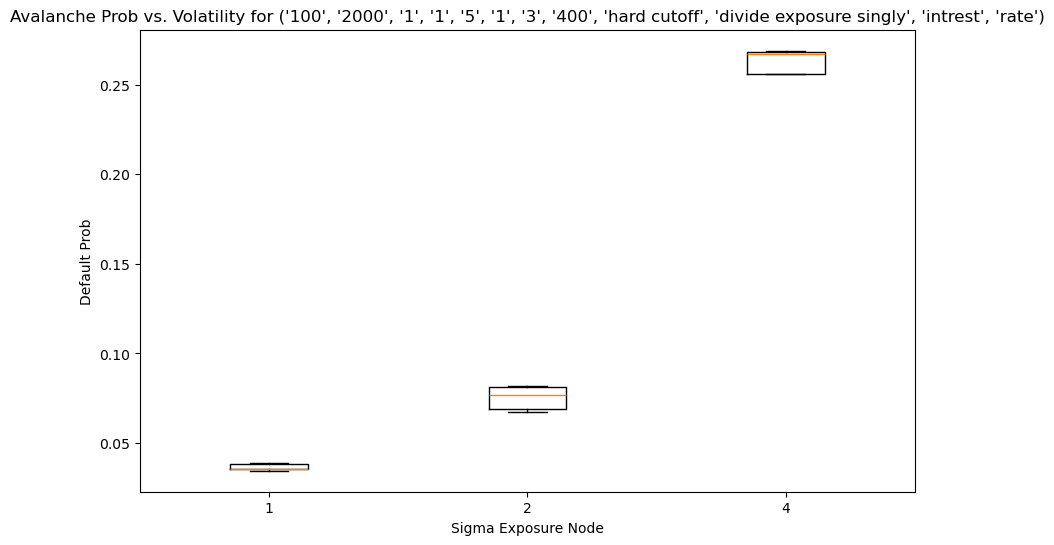

Key: ('100', '2000', '1', '1', '5', '1', '3', '400', 'hard cutoff', 'random link logic', 'exposure')
One or more groups have zero variance, performing non-parametric Kruskal-Wallis test.
Kruskal-Wallis Test Result:
H-statistic: 12.987012987012987
P-value: 0.0015132335505867215
Conclusion: There is a significant difference between the groups.


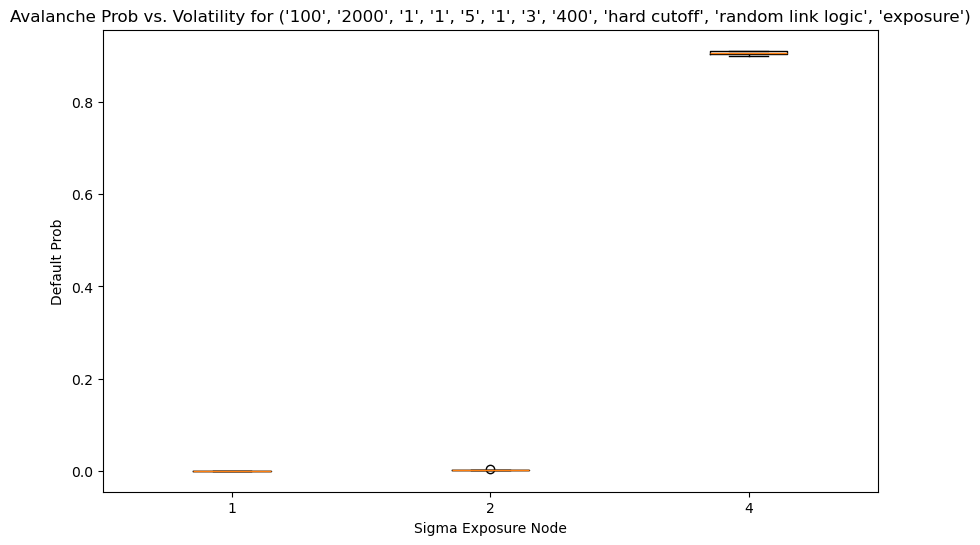

In [304]:
plot_avalanche_prob_vs_volatility(directory = directory_path, threshold = 10, mode='sigma_exposure_node')


In [305]:
def stress_vs_avalanche_prob_vs_volatility(directory:str = './', threshold = 10, mode:str = 'sigma_interest_rates'):
    
    groups = group_files(directory, mode)

    for key, value in groups.items():
        print("Key:", key)
        bankrupt_nodes_avg_list = []
        total_edge_exposures = []
        filenames = value['filenames']
        for filename in filenames:
            full_path = os.path.join(directory, filename)
            df = pd.read_csv(full_path)
            bankrupt_nodes = []
            for i in range(len(df)):
                if pd.isna(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]) or pd.isna(df['Number of Bankrupt Agents Over Time'].iloc[i]):
                    continue
                else: 
                    bankrupt_node = calculate_default_probability(ast.literal_eval(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]), threshold = threshold)
                    bankrupt_nodes.append(bankrupt_node)
            bankrupt_nodes_avg = np.mean(bankrupt_nodes)
            bankrupt_nodes_avg_list.append(bankrupt_nodes_avg)

            exposures = [ast.literal_eval(x) for x in df['Total Absolute Exposure in Edge Weights'] if not pd.isna(x)]
            exposures_avg = [np.mean(x) for x in exposures]
            total_edge_exposure_avg = np.mean(exposures_avg)
            total_edge_exposures.append(total_edge_exposure_avg)

            
        if mode == 'sigma_interest_rates':
            sigmas = value['sigma_interest_rates']
        if mode == 'sigma_exposure_node':
            sigmas = value['sigma_exposure_node']

        sigmas = [float(sigma) for sigma in sigmas]
        combined = sorted(zip(sigmas, bankrupt_nodes_avg_list, total_edge_exposures))
        sigmas_sorted, bankrupt_nodes_list_sorted, total_edge_exposures_sorted = zip(*combined)


    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_trisurf(sigmas_sorted, total_edge_exposures_sorted, bankrupt_nodes_list_sorted)

    ax.set_xlabel(mode.replace('_', ' ').title())
    ax.set_ylabel('Total Absolute Exposure in Edge Weights')
    ax.set_zlabel('Default Prob')
    ax.set_title('Stress vs. Avalanche Prob vs. Volatility', fontdict={'fontsize': 14})
    ax.view_init(elev=30, azim=60)

    model_summary = perform_regression(bankrupt_nodes_list_sorted, sigmas_sorted, total_edge_exposures_sorted)
    print(model_summary)

    plt.show()

Key: ('100', '2000', '1', '1', '5', '1', '3', '400', 'hard cutoff', 'divide exposure singly', 'intrest', 'rate')
Key: ('100', '2000', '1', '1', '5', '1', '3', '400', 'hard cutoff', 'random link logic', 'exposure')
                            OLS Regression Results                            
Dep. Variable:              dependent   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 01 Feb 2024   Prob (F-statistic):                nan
Time:                        17:03:42   Log-Likelihood:                 82.970
No. Observations:                   3   AIC:                            -159.9
Df Residuals:                       0   BIC:                            -162.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                      

c:\Users\nitai\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\nitai\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\nitai\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\nitai\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


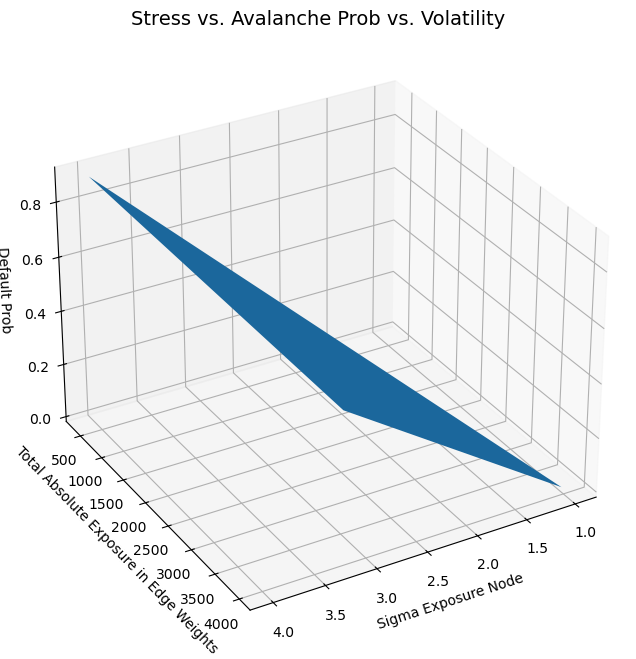

In [306]:
stress_vs_avalanche_prob_vs_volatility(directory=directory_path, mode = 'sigma_exposure_node')

# Plot 4

In [307]:
directory_path = R'./Data groupmates/Varying threshold/'

# List everything in the directory
all_items = os.listdir(directory_path)


In [308]:
all_items

['100_10000_1_1_1_10_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240131034804.csv',
 '100_10000_1_1_1_10_1_3_400_hard cutoff_random link logic_exposure_20240131023411.csv',
 '100_10000_1_1_1_15_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240131041723.csv',
 '100_10000_1_1_1_15_1_3_400_hard cutoff_random link logic_exposure_20240131024842.csv',
 '100_10000_1_1_1_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_20240131031931.csv',
 '100_10000_1_1_1_5_1_3_400_hard cutoff_random link logic_exposure_20240131022706.csv']

In [309]:
def get_statistics_vary_threshold_v(pattern: str = './200_2000_*.csv'):
    def safe_literal_eval(s):
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError):
            return np.nan

    def calculate_average_list(column):
        return column.apply(safe_literal_eval).apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)

    abs_diff_avg_per_run_per_threshold = {}

    for filepath in glob.glob(pattern):
        df = pd.read_csv(filepath)
        filename = os.path.basename(filepath).replace('.csv', '')
        parts = filename.split('_')
        threshold_v = float(parts[5])
        abs_diff_avg = calculate_average_list(df['Abs Difference of Bankrupt Agents Over Time'])
        if threshold_v not in abs_diff_avg_per_run_per_threshold:
            abs_diff_avg_per_run_per_threshold[threshold_v] = []
        abs_diff_avg_per_run_per_threshold[threshold_v].append(abs_diff_avg)

    return abs_diff_avg_per_run_per_threshold

In [310]:
def perform_pairwise_comparisons(data_to_plot1, data_to_plot2, thresholds):
    for i in range(min(len(data_to_plot1), len(data_to_plot2))):
        result = compare_group_means(data_to_plot1[i], data_to_plot2[i])
        print(f"Comparison for Threshold {thresholds[i]}: \n {result}\n")

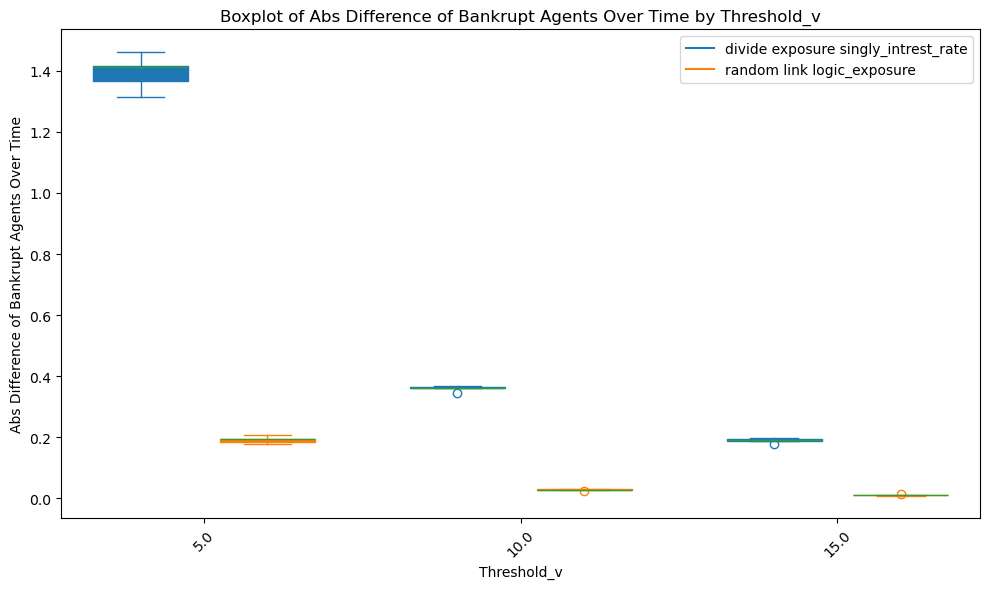

The data is normal and homogeneous, performing ANOVA.
Comparison for Threshold 5.0: 
 ANOVA Result:
            sum_sq   df            F        PR(>F)
C(group)  3.622475  1.0  2151.887136  5.153927e-11
Residual  0.013467  8.0          NaN           NaN
Conclusion: There is a significant difference between the groups.

The data is normal and homogeneous, performing ANOVA.
Comparison for Threshold 10.0: 
 ANOVA Result:
            sum_sq   df           F        PR(>F)
C(group)  0.274333  1.0  7115.82826  4.350703e-13
Residual  0.000308  8.0         NaN           NaN
Conclusion: There is a significant difference between the groups.

The data is normal and homogeneous, performing ANOVA.
Comparison for Threshold 15.0: 
 ANOVA Result:
            sum_sq   df            F        PR(>F)
C(group)  0.079852  1.0  2820.582328  1.751599e-11
Residual  0.000226  8.0          NaN           NaN
Conclusion: There is a significant difference between the groups.



In [311]:
# First dataset，our model
pattern1 = './Data groupmates/Varying threshold/100_10000_1_1_1_*_1_3_400_hard cutoff_divide exposure singly_intrest_rate_*.csv'
all_results1 = get_statistics_vary_threshold_v(pattern=pattern1)
data1 = all_results1
thresholds1 = list(data1.keys())
data_to_plot1 = []
for values in data1.values():
    flattened_values = [x for sublist in values for x in sublist if not np.isnan(x)]
    data_to_plot1.append(np.array(flattened_values))
sorted_data1 = sorted(zip(thresholds1, data_to_plot1), key=lambda x: x[0])
thresholds1, data_to_plot1 = zip(*sorted_data1)

# Second dataset, paper model
pattern2 = './Data groupmates/Varying threshold/100_10000_1_1_1_*_1_3_400_hard cutoff_random link logic_exposure_*.csv'
all_results2 = get_statistics_vary_threshold_v(pattern=pattern2)
data2 = all_results2
thresholds2 = list(data2.keys())
data_to_plot2 = []
for values in data2.values():
    flattened_values = [x for sublist in values for x in sublist if not np.isnan(x)]
    data_to_plot2.append(np.array(flattened_values))
# Sorting the data by threshold values in ascending order
sorted_data2 = sorted(zip(thresholds2, data_to_plot2), key=lambda x: x[0])
thresholds2, data_to_plot2 = zip(*sorted_data2)

# Creating the boxplot
plt.figure(figsize=(10, 6))

# Plotting the boxplot for the first dataset
bp1 = plt.boxplot(data_to_plot1, positions=np.array(range(len(data_to_plot1)))*2.0-0.4, widths=0.6, patch_artist=True, boxprops=dict(facecolor='C0', color='C0'), whiskerprops=dict(color='C0'), capprops=dict(color='C0'), medianprops=dict(color='C2'), flierprops=dict(markeredgecolor='C0'))

# Plotting the boxplot for the second dataset
bp2 = plt.boxplot(data_to_plot2, positions=np.array(range(len(data_to_plot2)))*2.0+0.4, widths=0.6, patch_artist=True, boxprops=dict(facecolor='C1', color='C1'), whiskerprops=dict(color='C1'), capprops=dict(color='C1'), medianprops=dict(color='C2'), flierprops=dict(markeredgecolor='C1'))

# Adding dummy lines for the legend
plt.plot([], c='C0', label='divide exposure singly_intrest_rate')
plt.plot([], c='C1', label='random link logic_exposure')

# Setting the axis labels and title
plt.xlabel('Threshold_v')
plt.ylabel('Abs Difference of Bankrupt Agents Over Time')
plt.title('Boxplot of Abs Difference of Bankrupt Agents Over Time by Threshold_v')

# Setting the tick labels on the x-axis
plt.xticks(np.arange(0, len(thresholds1) * 2, 2), thresholds1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()



plt.show()
# Call the compare_group_means function with your datasets
perform_pairwise_comparisons(data_to_plot1, data_to_plot2, thresholds1)